# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 500)

#def load_housing_data(housing_path=HOUSING_PATH):
#    csv_path = os.path.join(housing_path, "housing.csv")
#    return pd.read_csv(csv_path)

DATASET_PATH = "datasets/uci/"
def load_uci_data(path):
    csv_path = os.path.join(DATASET_PATH, path)
    return pd.read_csv(csv_path)

In [5]:
#housing = load_housing_data()
#housing.head()

#Otros candidatos a agregar:

# Producto 11: Incidencia por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto11

# Producto 26: Casos nuevos con sintomas por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto26

# Producto 27: Casos nuevos sin sintomas por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto27

# Producto 38: Casos fallecidos por comuna (usar CasosFallecidosPorComuna_std)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto38

# -------------------------------------------------------------------------------

# Producto 8: Pacientes COVID UCI (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto8
uci_region = load_uci_data("UCI_T.csv")

# Producto 19: Casos activos (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto19
casos_activos = load_uci_data("ActivosComuna_std.csv") #Nuevo

# Producto 20: Número de ventiladores
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto20
vent_disp = load_uci_data("NumeroVentiladores_T.csv")

# Producto 23: Pacientes críticos
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto23
uci_covid_nacional = load_uci_data("PacientesCriticos_T.csv")

# Producto 24: Camas Hospital Diario
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto24
camas = load_uci_data("CamasHospital_Diario_T.csv")

# Producto 35: Comorbilidad
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto35
comorb_nacional = load_uci_data("Comorbilidad_T.csv")

# Producto 37: Defunciones
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto37
defunc_nacional = load_uci_data("Defunciones_T.csv")

# Productos 38: Casos fallecidos por comuna
#https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto38
defunc_regional = load_uci_data("CasosFallecidosComuna_std.csv")   

# Producto 44: Evolución semanal de egresos hospitalarios pacientes COVID-19
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto44
egresos_nacional = load_uci_data("Egresos_std.csv") #Nuevo

# Producto 52: Camas Hospital (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto52
camas_region = load_uci_data("CamasHospital_Regional_std.csv")

# Producto 74: Paso a paso
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto74
paso_a_paso = load_uci_data("paso_a_paso_T.csv")

# Producto 76: Avance en Campaña de Vacunación COVID-19
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto76
Vacunacion = pd.read_csv(os.path.join("datasets/uci/", "vacunacion_t.txt"), sep=",", header=None)

## Limpieza de datos

In [6]:
from statistics import mode

camas_region = camas_region[camas_region["Region"].str.match("Metropolitana")]
camas_region = camas_region.groupby(["Fecha", "Serie"])["Fecha", "Serie", "Casos"].sum().reset_index()
camas_region = camas_region.pivot_table(index=['Fecha'], columns=['Serie'], values='Casos').fillna(0)
#camas_region.set_index(camas_region["Fecha"], inplace=True)
#camas_region.drop(axis=1, labels="Fecha", inplace=True)
camas_region.drop(axis=1, labels="Camas base (2019)", inplace=True)

camas_region.index.name=None

#Tenemos tambien las camas nacionales, pero es preferible usar las regionales
camas.columns = ['Fecha', 'Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.', 'Camas UCI nac.']
camas.set_index(camas["Fecha"], drop=True, inplace=True)
camas.drop(axis=1, labels=["Fecha"], inplace=True)
camas.index.name = None


comorb_nacional.drop(comorb_nacional.columns[[*range(1,12)]], axis=1, inplace=True)
comorb_nacional.columns = ['Comorbilidad', 'Hipertensión arterial', 'Diabetes', 'Obesidad', 'Asma',
       'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica']
comorb_nacional.drop([0],axis=0, inplace=True)
comorb_nacional.set_index(comorb_nacional["Comorbilidad"], drop=True, inplace=True)
comorb_nacional.drop(axis=1, labels=["Comorbilidad"], inplace=True)
comorb_nacional.index.name = None

defunc_nacional = defunc_nacional[["Fecha","Defunciones_2020-07-16"]]
defunc_nacional.columns = ["Fecha", "Defunciones nacional"]
defunc_nacional.set_index(defunc_nacional["Fecha"], inplace=True)
defunc_nacional.drop(axis=1, labels="Fecha", inplace=True)
defunc_nacional.index.name = None

defunc_regional = defunc_regional[4:]
defunc_regional.set_index(defunc_regional["Region"], inplace=True)
defunc_regional = defunc_regional.iloc[:,95:148]
defunc_regional = defunc_regional.apply(pd.to_numeric)
defunc_regional["Defunciones regional"] = defunc_regional.sum(axis=1,numeric_only=True)
defunc_regional.index.name = None
defunc_regional = defunc_regional["Defunciones regional"]

vent_disp.columns = ["Fecha", "Total vent.", "Vent. ocupados", "Vent. disponibles"]
vent_disp.set_index(vent_disp["Fecha"], inplace=True)
vent_disp.drop(axis=1, labels="Fecha", inplace=True)
vent_disp.index.name = None

uci_covid_nacional.columns = ["Fecha", "Pac. criticos nacional"]
uci_covid_nacional.set_index(uci_covid_nacional["Fecha"], inplace=True)
uci_covid_nacional.drop(axis=1, labels="Fecha", inplace=True)
uci_covid_nacional.index.name = None

uci_region = uci_region[["Region", "Metropolitana"]]
uci_region.columns = ["Fecha", "Casos diarios region"]
uci_region.drop([0,1],axis=0, inplace=True)
uci_region.set_index(uci_region["Fecha"], inplace=True)
uci_region.drop(axis=1, labels="Fecha", inplace=True)
uci_region.index.name = None

#casos_activos = casos_activos.rename(columns = {'Casos activos':'Casos activos region'})
casos_activos = casos_activos.loc[:,["Region", "Fecha", "Casos activos"]]
casos_activos.columns = ["Region", "Fecha", "Casos activos region"]
casos_activos = casos_activos[casos_activos["Region"].str.match("Metropolitana")]
casos_activos = casos_activos.groupby("Fecha")["Fecha", "Casos activos region"].sum().reset_index()
casos_activos.set_index(casos_activos["Fecha"], inplace=True)
casos_activos.drop(axis=1, labels="Fecha", inplace=True)
casos_activos.index.name=None

#paso_a_paso = paso_a_paso.iloc[4:,:]
#paso_a_paso.set_index(paso_a_paso["codigo_region"], drop=True, inplace=True)
#paso_a_paso.drop(axis=1, labels=["codigo_region"], inplace=True)
#paso_a_paso.index.name = None
#moda = [mode(paso_a_paso.iloc[i,:]) for i in range(paso_a_paso.shape[0])]
#moda = np.asarray(moda)
#paso_a_paso["Paso a paso"] = moda
#paso_a_paso = pd.to_numeric(paso_a_paso.iloc[:,-1], downcast='float')

# Este requiere tratamiento
#egresos_nacional = egresos_nacional[["Fecha Publicación", "Egresos"]]
#egresos_nacional.set_index(egresos_nacional["Fecha Publicación"],inplace=True)
#egresos_nacional.drop(axis=1, labels="Fecha Publicación", inplace=True)
#egresos_nacional.index.name = None



#camas.set_index(camas["Tipo de cama"], drop=True)
#amas.drop(axis=1, labels=["Tipo de cama"])

#amas.set_index(camas["Tipo de cama"], drop=True)
#amas.drop(axis=1, labels=["Tipo de cama"])

<ipython-input-6-c255ce664d70>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  camas_region = camas_region.groupby(["Fecha", "Serie"])["Fecha", "Serie", "Casos"].sum().reset_index()
<ipython-input-6-c255ce664d70>:65: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  casos_activos = casos_activos.groupby("Fecha")["Fecha", "Casos activos region"].sum().reset_index()


In [7]:
#ESTE
paso_a_paso = paso_a_paso.drop([1,2,3])
paso_a_paso

,codigo_region,15,15.1,15.2,15.3,15.4,1,1.1,1.2,1.3,...,12.2,12.3,12.4,12.5,12.6,12.7,12.8,12.9,12.10,12.11
0,region_residencia,Arica y Parinacota,Arica y Parinacota,Arica y Parinacota,Arica y Parinacota,Arica y Parinacota,Tarapacá,Tarapacá,Tarapacá,Tarapacá,...,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes
4,2020-07-28,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3
5,2020-07-29,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3
6,2020-07-30,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3
7,2020-07-31,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3
8,2020-08-01,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3
9,2020-08-02,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3
10,2020-08-03,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3
11,2020-08-04,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3
12,2020-08-05,3,1,3,3,3,1,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [8]:
#ESTE

paso_a_paso.set_index("codigo_region", drop=True, inplace=True)
paso_a_paso.index.name = "Fecha"

#paso_a_paso1.drop(["codigo_region"], axis=1)
paso_a_paso

,15,15.1,15.2,15.3,15.4,1,1.1,1.2,1.3,1.4,...,12.2,12.3,12.4,12.5,12.6,12.7,12.8,12.9,12.10,12.11
Fecha,,,,,,,,,,,,,,,,,,,,,
region_residencia,Arica y Parinacota,Arica y Parinacota,Arica y Parinacota,Arica y Parinacota,Arica y Parinacota,Tarapacá,Tarapacá,Tarapacá,Tarapacá,Tarapacá,...,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes,Magallanes
2020-07-28,3,1,3,3,3,1,3,3,3,1,...,3,3,3,3,3,3,3,3,3,3
2020-07-29,3,1,3,3,3,1,3,3,3,1,...,3,3,3,3,3,3,3,3,3,3
2020-07-30,3,1,3,3,3,1,3,3,3,1,...,3,3,3,3,3,3,3,3,3,3
2020-07-31,3,1,3,3,3,1,3,3,3,1,...,3,3,3,3,3,3,3,3,3,3
2020-08-01,3,1,3,3,3,1,3,3,3,1,...,3,3,3,3,3,3,3,3,3,3
2020-08-02,3,1,3,3,3,1,3,3,3,1,...,3,3,3,3,3,3,3,3,3,3
2020-08-03,3,1,3,3,3,1,3,3,3,1,...,3,3,3,3,3,3,3,3,3,3
2020-08-04,3,1,3,3,3,1,3,3,3,1,...,3,3,3,3,3,3,3,3,3,3


In [9]:
#ESTE
i=0
modaArica = []
modaTarapaca = []
modaAntofagasta = []
modaAtacama = []
modaCoquimbo = []
modaValparaiso = []
modaMetropolitana = []
modaOHiggins = []
modaMaule = []
modaNuble = []
modaBiobio = []
modaAraucania = []
modaLosRios = []
modaLosLagos = []
modaAysen = []
modaMagallanes = []

while(i<len(paso_a_paso)):
    modaArica.append(mode(paso_a_paso[["15", "15.1", "15.2", "15.3", "15.4"]].iloc[i,:]))
    modaTarapaca.append(mode(paso_a_paso[["1", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7"]].iloc[i,:]))
    modaAntofagasta.append(mode(paso_a_paso[["2","2.1","2.2","2.3","2.4","2.5","2.6","2.7","2.8","2.9","2.10","2.11"]].iloc[i,:]))
    modaAtacama.append(mode(paso_a_paso[["3","3.1","3.2","3.3","3.4","3.5","3.6","3.7","3.8"]].iloc[i,:]))
    modaCoquimbo.append(mode(paso_a_paso[["4","4.1","4.2","4.3","4.4","4.5","4.6","4.7","4.8","4.9","4.10","4.11","4.12","4.13","4.14"]].iloc[i,:]))
    modaValparaiso.append(mode(paso_a_paso[["5","5.1","5.2","5.3","5.4","5.5","5.6","5.7","5.8","5.9","5.10","5.11","5.12","5.13","5.14","5.15","5.16","5.17","5.18","5.19","5.20","5.21","5.22","5.23","5.24","5.25","5.26","5.27","5.28","5.29","5.30","5.31","5.32","5.33","5.34","5.35","5.36","5.37"]].iloc[i,:]))
    modaMetropolitana.append(mode(paso_a_paso[["13","13.1","13.2","13.3","13.4","13.5","13.6","13.7","13.8","13.9","13.10","13.11","13.12","13.13","13.14","13.15","13.16","13.17","13.18","13.19","13.20","13.21","13.22","13.23","13.24","13.25","13.26","13.27","13.28","13.29","13.30","13.31","13.32","13.33","13.34","13.35","13.36","13.37","13.38","13.39","13.40","13.41","13.42","13.43","13.44","13.45","13.46","13.47","13.48","13.49","13.50","13.51","13.52","13.53","13.54"]].iloc[i,:]))
    modaOHiggins.append(mode(paso_a_paso[["6","6.1","6.2","6.3","6.4","6.5","6.6","6.7","6.8","6.9","6.10","6.11","6.12","6.13","6.14","6.15","6.16","6.17","6.18","6.19","6.20","6.21","6.22","6.23","6.24","6.25","6.26","6.27","6.28","6.29","6.30","6.31","6.32"]].iloc[i,:]))
    modaMaule.append(mode(paso_a_paso[["7","7.1","7.2","7.3","7.4","7.5","7.6","7.7","7.8","7.9","7.10","7.11","7.12","7.13","7.14","7.15","7.16","7.17","7.18","7.19","7.20","7.21","7.22","7.23","7.24","7.25","7.26","7.27","7.28","7.29","7.30","7.31","7.32","7.33"]].iloc[i,:]))
    modaNuble.append(mode(paso_a_paso[["16","16.1","16.2","16.3","16.4","16.5","16.6","16.7","16.8","16.9","16.10","16.11","16.12","16.13","16.14","16.15","16.16","16.17","16.18","16.19","16.20","16.21","16.22"]].iloc[i,:]))
    modaBiobio.append(mode(paso_a_paso[["8","8.1","8.2","8.3","8.4","8.5","8.6","8.7","8.8","8.9","8.10","8.11","8.12","8.13","8.14","8.15","8.16","8.17","8.18","8.19","8.20","8.21","8.22","8.23","8.24","8.25","8.26","8.27","8.28","8.29","8.30","8.31","8.32","8.33","8.34"]].iloc[i,:]))
    modaAraucania.append(mode(paso_a_paso[["9","9.1","9.2","9.3","9.4","9.5","9.6","9.7","9.8","9.9","9.10","9.11","9.12","9.13","9.14","9.15","9.16","9.17","9.18","9.19","9.20","9.21","9.22","9.23","9.24","9.25","9.26","9.27","9.28","9.29","9.30","9.31","9.32","9.33","9.34","9.35"]].iloc[i,:]))
    modaLosRios.append(mode(paso_a_paso[["14","14.1","14.2","14.3","14.4","14.5","14.6","14.7","14.8","14.9","14.10","14.11","14.12"]].iloc[i,:]))
    modaLosLagos.append(mode(paso_a_paso[["10","10.1","10.2","10.3","10.4","10.5","10.6","10.7","10.8","10.9","10.10","10.11","10.12","10.13","10.14","10.15","10.16","10.17","10.18","10.19","10.20","10.21","10.22","10.23","10.24","10.25","10.26","10.27","10.28","10.29","10.30","10.31","10.32","10.33","10.34","10.35","10.36","10.37"]].iloc[i,:]))
    modaAysen.append(mode(paso_a_paso[["11","11.1","11.2","11.3","11.4","11.5","11.6","11.7","11.8","11.9","11.10","11.11","11.12","11.13","11.14","11.15","11.16","11.17","11.18","11.19"]].iloc[i,:]))
    modaMagallanes.append(mode(paso_a_paso[["12","12.1","12.2","12.3","12.4","12.5","12.6","12.7","12.8","12.9","12.10","12.11"]].iloc[i,:]))
    i = i+1   

paso_a_paso["Arica y Parinacota"] = modaArica
paso_a_paso["Tarapacá"] = modaTarapaca
paso_a_paso["Antofagasta"] = modaAntofagasta
paso_a_paso["Atacama"] = modaAtacama
paso_a_paso["Coquimbo"] = modaCoquimbo
paso_a_paso["Valparaíso"] = modaValparaiso
paso_a_paso["Metropolitana"] = modaMetropolitana
paso_a_paso["O'Higgins"] = modaOHiggins
paso_a_paso["Maule"] = modaMaule
paso_a_paso["Nuble"] = modaNuble
paso_a_paso["Biobío"] = modaBiobio
paso_a_paso["Araucania"] = modaAraucania
paso_a_paso["Los Rios"] = modaLosRios
paso_a_paso["Los Lagos"] = modaLosLagos
paso_a_paso["Aysén"] = modaAysen
paso_a_paso["Magallanes"] = modaMagallanes




In [10]:
#ESTE
paso_a_paso = paso_a_paso.drop(columns=["15", "15.1", "15.2", "15.3", "15.4",
                            "1", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7",
                            "2","2.1","2.2","2.3","2.4","2.5","2.6","2.7","2.8","2.9","2.10","2.11",
                            "3","3.1","3.2","3.3","3.4","3.5","3.6","3.7","3.8",
                            "4","4.1","4.2","4.3","4.4","4.5","4.6","4.7","4.8","4.9","4.10","4.11","4.12","4.13","4.14",
                            "5","5.1","5.2","5.3","5.4","5.5","5.6","5.7","5.8","5.9","5.10","5.11","5.12","5.13","5.14","5.15","5.16","5.17","5.18","5.19","5.20","5.21","5.22","5.23","5.24","5.25","5.26","5.27","5.28","5.29","5.30","5.31","5.32","5.33","5.34","5.35","5.36","5.37",
                            "13","13.1","13.2","13.3","13.4","13.5","13.6","13.7","13.8","13.9","13.10","13.11","13.12","13.13","13.14","13.15","13.16","13.17","13.18","13.19","13.20","13.21","13.22","13.23","13.24","13.25","13.26","13.27","13.28","13.29","13.30","13.31","13.32","13.33","13.34","13.35","13.36","13.37","13.38","13.39","13.40","13.41","13.42","13.43","13.44","13.45","13.46","13.47","13.48","13.49","13.50","13.51","13.52","13.53","13.54",
                            "6","6.1","6.2","6.3","6.4","6.5","6.6","6.7","6.8","6.9","6.10","6.11","6.12","6.13","6.14","6.15","6.16","6.17","6.18","6.19","6.20","6.21","6.22","6.23","6.24","6.25","6.26","6.27","6.28","6.29","6.30","6.31","6.32",
                            "7","7.1","7.2","7.3","7.4","7.5","7.6","7.7","7.8","7.9","7.10","7.11","7.12","7.13","7.14","7.15","7.16","7.17","7.18","7.19","7.20","7.21","7.22","7.23","7.24","7.25","7.26","7.27","7.28","7.29","7.30","7.31","7.32","7.33",
                            "16","16.1","16.2","16.3","16.4","16.5","16.6","16.7","16.8","16.9","16.10","16.11","16.12","16.13","16.14","16.15","16.16","16.17","16.18","16.19","16.20","16.21","16.22",
                            "8","8.1","8.2","8.3","8.4","8.5","8.6","8.7","8.8","8.9","8.10","8.11","8.12","8.13","8.14","8.15","8.16","8.17","8.18","8.19","8.20","8.21","8.22","8.23","8.24","8.25","8.26","8.27","8.28","8.29","8.30","8.31","8.32","8.33","8.34",
                            "9","9.1","9.2","9.3","9.4","9.5","9.6","9.7","9.8","9.9","9.10","9.11","9.12","9.13","9.14","9.15","9.16","9.17","9.18","9.19","9.20","9.21","9.22","9.23","9.24","9.25","9.26","9.27","9.28","9.29","9.30","9.31","9.32","9.33","9.34","9.35",
                            "14","14.1","14.2","14.3","14.4","14.5","14.6","14.7","14.8","14.9","14.10","14.11","14.12",
                            "10","10.1","10.2","10.3","10.4","10.5","10.6","10.7","10.8","10.9","10.10","10.11","10.12","10.13","10.14","10.15","10.16","10.17","10.18","10.19","10.20","10.21","10.22","10.23","10.24","10.25","10.26","10.27","10.28","10.29","10.30","10.31","10.32","10.33","10.34","10.35","10.36","10.37",
                            "11","11.1","11.2","11.3","11.4","11.5","11.6","11.7","11.8","11.9","11.10","11.11","11.12","11.13","11.14","11.15","11.16","11.17","11.18","11.19",
                            "12","12.1","12.2","12.3","12.4","12.5","12.6","12.7","12.8","12.9","12.10","12.11"]) 

In [11]:
#ESTE
paso_a_paso = paso_a_paso.drop(["region_residencia"])

#paso_a_paso

In [12]:
#ESTE
i=0
j=0

while(i < len(paso_a_paso)):
    while(j<len(paso_a_paso.columns)):
        if(paso_a_paso.iloc[i,j] == '1'):
             paso_a_paso.iloc[i,j] = 0.98
        if(paso_a_paso.iloc[i,j] == '2'):
            paso_a_paso.iloc[i,j] = 0.45
        if(paso_a_paso.iloc[i,j] == '3'):
            paso_a_paso.iloc[i,j] = 0.25
        if(paso_a_paso.iloc[i,j] == '4'):
            paso_a_paso.iloc[i,j] = 0.25
        if(paso_a_paso.iloc[i,j] == '5'):
            paso_a_paso.iloc[i,j] = 0.25
        j=j+1
    i=i+1
    j=0

paso_a_paso

,Arica y Parinacota,Tarapacá,Antofagasta,Atacama,Coquimbo,Valparaíso,Metropolitana,O'Higgins,Maule,Nuble,Biobío,Araucania,Los Rios,Los Lagos,Aysén,Magallanes
Fecha,,,,,,,,,,,,,,,,
2020-07-28,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2020-07-29,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2020-07-30,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2020-07-31,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2020-08-01,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2020-08-02,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2020-08-03,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2020-08-04,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2020-08-05,0.25,0.25,0.25,0.25,0.25,0.25,0.98,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


In [13]:
#ESTE
paso_a_paso["Promedio nacional de encierro"] = paso_a_paso.mean(axis=1)
#while(i<len(paso_a_paso)):

In [14]:
#ESTE
paso_a_paso = paso_a_paso[["Promedio nacional de encierro"]]


In [15]:
# Ajuste de datos de vacunacion
Vacunacion = Vacunacion[[0, 1, 2, 3]]
Vacunacion.columns = ["Fecha", "Primera_V", "Segunda_V", "V_Unica"]
Vacunacion = Vacunacion.drop([0,1])
Vacunacion.set_index("Fecha", drop=True, inplace=True)

i=0
anterior = 0
tmp_list = []
while(i < len(Vacunacion)):
    tmp_list.append(int(float(Vacunacion["Primera_V"][i])) - anterior)
    anterior = int(float(Vacunacion["Primera_V"][i]))
    i=i+1

Vacunacion["Primera_V_Daily"] = tmp_list

i=0
anterior = 0
tmp_list = []
while(i < len(Vacunacion)):
    tmp_list.append(int(float(Vacunacion["Segunda_V"][i])) - anterior)
    anterior = int(float(Vacunacion["Segunda_V"][i]))
    i=i+1
    
Vacunacion["Segunda_V_Daily"] = tmp_list

i=0
anterior = 0
tmp_list = []
while(i < len(Vacunacion)):
    tmp_list.append(int(float(Vacunacion["V_Unica"][i])) - anterior)
    anterior = int(float(Vacunacion["V_Unica"][i]))
    i=i+1
    
Vacunacion["V_Unica_Daily"] = tmp_list
Vacunacion = Vacunacion[["Primera_V_Daily", "Segunda_V_Daily", "V_Unica_Daily"]]
Vacunacion.columns = ["Primera_V", "Segunda_V", "V_Unica"]

In [16]:
#ESTE
data = pd.merge(camas, comorb_nacional, how='outer',left_index=True, right_index=True)
data = pd.merge(data, camas_region, how='outer', left_index=True, right_index=True)
data = pd.merge(data, defunc_nacional,how='outer',left_index=True, right_index=True)
data = pd.merge(data, defunc_regional,how='outer',left_index=True, right_index=True)
data = pd.merge(data, vent_disp,how='outer', left_index=True, right_index=True)
data = pd.merge(data, uci_covid_nacional,how='outer', left_index=True, right_index=True)
data = pd.merge(data, uci_region,how='outer', left_index=True, right_index=True)
data = pd.merge(data, casos_activos,how='outer', left_index=True, right_index=True)
data = pd.merge(data, paso_a_paso,how='outer', left_index=True, right_index=True)
data = pd.merge(data, Vacunacion,how='outer', left_index=True, right_index=True)

data = data.loc['2020-04-14':]
data.index = pd.to_datetime(data.index)
for col in data:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [17]:
#ESTE
i=0
while(i < len(data)):
    if(data[["Promedio nacional de encierro"]].isnull().iloc[i,0]):
        data["Promedio nacional de encierro"][i] = 0
    i=i+1

In [18]:
#tmp_data = data[["Primera_V", "Segunda_V", "V_Unica"]].loc[data["Primera_V"].isnull()].replace(to_replace = np.nan, value = 0, inplace = True)
#tmp_data.append(data[["Primera_V", "Segunda_V", "V_Unica"]].loc[not data["Primera_V"].isnull()])
#data

#data[["Primera_V", "Segunda_V", "V_Unica"]][~data["Primera_V"].isnull()]
i=0
while(i < len(data)):
    if(data[["Primera_V"]].isnull().iloc[i,0]):
        data["Primera_V"][i] = 0
        data["Segunda_V"][i] = 0
        data["V_Unica"][i] = 0
    i = i+1


In [19]:
#uci_region
# VER UMBRAL y proporción de NaNs
#data.columns
data_rows = data.shape[0]
nan_proportions = data.apply(lambda x: x.isnull().sum() / data_rows, axis=0).to_frame()
#nan_proportions
data_non_imputable = nan_proportions.loc[nan_proportions[0] >= 0.15]
data_non_imputable
#type(nan_proportions)

#data1.apply(lambda x: x.interpolate())

# Hacer


,0
Hipertensión arterial,0.767010
Diabetes,0.767010
Obesidad,0.767010
Asma,0.767010
Enfermedad cardiovascular,0.767010
Enfermedad pulmonar crónica,0.767010
Cardiopatía crónica,0.767010
Enfermedad renal crónica,0.767010
Enfermedad neurológica crónica,0.767010
Inmunocomprometido,0.767010


In [20]:
inputable = nan_proportions.loc[nan_proportions[0] <= 0.15]
inputable

,0
Camas basicas nac.,0.090722
Camas medias nac.,0.090722
Camas UTI nac.,0.090722
Camas UCI nac.,0.090722
Camas UCI habilitadas,0.088660
Camas UCI ocupadas COVID-19,0.088660
Camas UCI ocupadas no COVID-19,0.088660
Total vent.,0.086598
Vent. ocupados,0.086598
Vent. disponibles,0.086598


In [21]:
#data = data.assign(Hipertensión_arterial_interp=data["Hipertensión arterial"].interpolate(method='spline', order=3, inplace=True))

#Columnas con <15% casos faltantes
data["Camas basicas nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas medias nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UTI nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI habilitadas"].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI ocupadas COVID-19"].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI ocupadas no COVID-19"].interpolate(method='spline', order=2, inplace=True)

#Columnas con >15% casos faltantes
data["Pac. criticos nacional"].rolling(24, min_periods=1,).median()
data["Hipertensión arterial"].interpolate(method='linear', inplace=True)
data["Diabetes"].interpolate(method='linear', inplace=True)
data["Obesidad"].interpolate(method='linear', inplace=True)
data["Asma"].interpolate(method='linear', inplace=True)
data["Enfermedad cardiovascular"].interpolate(method='linear', inplace=True)
data["Enfermedad pulmonar crónica"].interpolate(method='linear', inplace=True)
data["Cardiopatía crónica"].interpolate(method='linear', inplace=True)
data["Enfermedad renal crónica"].interpolate(method='linear', inplace=True)
data["Enfermedad neurológica crónica"].interpolate(method='linear', inplace=True)
data["Inmunocomprometido"].interpolate(method='linear', inplace=True)
data["Enfermedad hepática crónica"].interpolate(method='linear', inplace=True)
data["Defunciones nacional"].rolling(24, min_periods=1,).median()
data["Defunciones regional"].interpolate(method='linear', inplace=True)
data["Casos activos region"].interpolate(method='spline', order=3, inplace=True)

#data["Pac. criticos nacional"].interpolate(method='time', inplace=True)
#data["Hipertensión arterial"].interpolate(method='time', inplace=True)
#data["Diabetes"].interpolate(method='time', inplace=True)
#data["Obesidad"].interpolate(method='time', inplace=True)
#data["Asma"].interpolate(method='time', inplace=True)
#data["Enfermedad cardiovascular"].interpolate(method='time', inplace=True)
#data["Enfermedad pulmonar crónica"].interpolate(method='time', inplace=True)
#data["Cardiopatía crónica"].interpolate(method='time', inplace=True)
#data["Enfermedad renal crónica"].interpolate(method='time', inplace=True)
#data["Enfermedad neurológica crónica"].interpolate(method='time', inplace=True)
#data["Inmunocomprometido"].interpolate(method='time', inplace=True)
#data["Enfermedad hepática crónica"].interpolate(method='time', inplace=True)
#data["Defunciones nacional"].interpolate(method='time', inplace=True)
#data["Casos activos region"].interpolate(method='time', inplace=True)

#for col in list(inputable.index):
#    print(col)
#    data = inputData(col, data)

In [22]:
data.apply(lambda x: x.isnull().sum() / data_rows, axis=0).to_frame()

,0
Camas basicas nac.,0.004124
Camas medias nac.,0.004124
Camas UTI nac.,0.004124
Camas UCI nac.,0.004124
Hipertensión arterial,0.084536
Diabetes,0.084536
Obesidad,0.084536
Asma,0.084536
Enfermedad cardiovascular,0.084536
Enfermedad pulmonar crónica,0.084536


In [23]:
data.isnull().sum(axis=1)

2020-04-14    17
2020-04-15    16
2020-04-16    12
2020-04-17    12
2020-04-18    12
2020-04-19    12
2020-04-20    12
2020-04-21    12
2020-04-22    12
2020-04-23    12
2020-04-24    12
2020-04-25    12
2020-04-26    12
2020-04-27    12
2020-04-28    12
2020-04-29    12
2020-04-30    12
2020-05-01    12
2020-05-02    12
2020-05-03    12
2020-05-04    12
2020-05-05    12
2020-05-06    12
2020-05-07    12
2020-05-08    12
2020-05-09    12
2020-05-10    12
2020-05-11    12
2020-05-12    12
2020-05-13    12
2020-05-14    12
2020-05-15    12
2020-05-16    12
2020-05-17    12
2020-05-18    12
2020-05-19    12
2020-05-20    12
2020-05-21    12
2020-05-22    12
2020-05-23    12
2020-05-24    12
2020-05-25     1
2020-05-26     1
2020-05-27     1
2020-05-28     1
2020-05-29     1
2020-05-30     1
2020-05-31     1
2020-06-01     1
2020-06-02     1
2020-06-03     1
2020-06-04     1
2020-06-05     1
2020-06-06     1
2020-06-07     1
2020-06-08     1
2020-06-09     1
2020-06-10     1
2020-06-11    

In [24]:
data = data.loc['2020-06-12':'2021-06-30']

In [25]:
data.isnull().sum(axis=1)

2020-06-12    0
2020-06-13    0
2020-06-14    0
2020-06-15    0
2020-06-16    0
2020-06-17    0
2020-06-18    0
2020-06-19    0
2020-06-20    0
2020-06-21    0
2020-06-22    0
2020-06-23    0
2020-06-24    0
2020-06-25    0
2020-06-26    0
2020-06-27    0
2020-06-28    0
2020-06-29    0
2020-06-30    0
2020-07-01    0
2020-07-02    0
2020-07-03    0
2020-07-04    0
2020-07-05    0
2020-07-06    0
2020-07-07    0
2020-07-08    0
2020-07-09    0
2020-07-10    0
2020-07-11    0
2020-07-12    0
2020-07-13    0
2020-07-14    0
2020-07-15    1
2020-07-16    1
2020-07-17    1
2020-07-18    1
2020-07-19    1
2020-07-20    1
2020-07-21    1
2020-07-22    1
2020-07-23    1
2020-07-24    1
2020-07-25    1
2020-07-26    1
2020-07-27    1
2020-07-28    1
2020-07-29    1
2020-07-30    1
2020-07-31    1
2020-08-01    1
2020-08-02    1
2020-08-03    1
2020-08-04    1
2020-08-05    1
2020-08-06    1
2020-08-07    1
2020-08-08    1
2020-08-09    1
2020-08-10    1
2020-08-11    1
2020-08-12    1
2020-08-

## Visualización de los datos

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [15, 10]

Text(0, 0.5, 'Cantidad de vacunados')

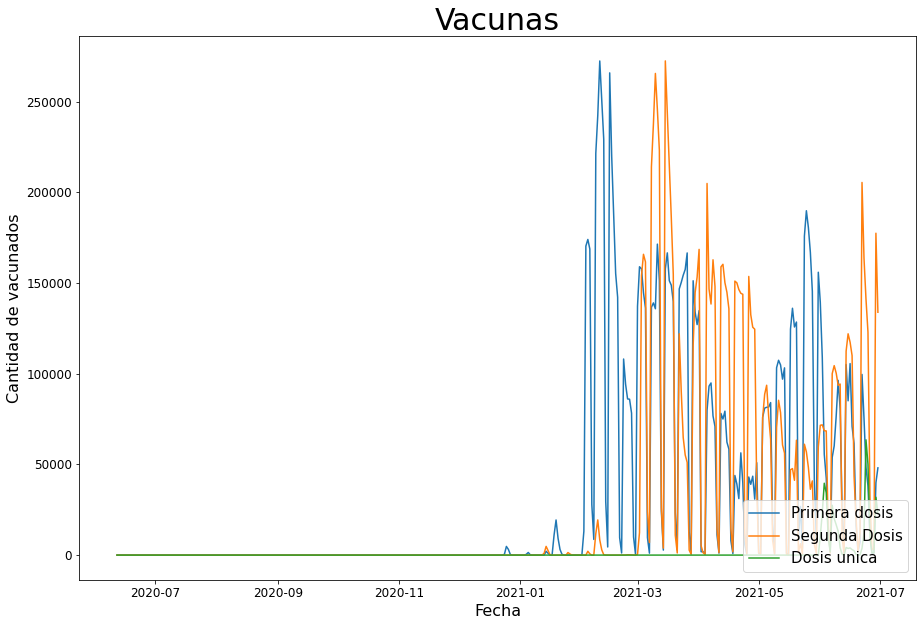

In [27]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data.iloc[:,[27, 28, 29]])
ax1.legend(('Primera dosis', 'Segunda Dosis', 'Dosis unica'), fontsize=15 , loc=4)
plt.title("Vacunas", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad de vacunados", fontsize=16)

Text(0, 0.5, 'Cantidad camas')

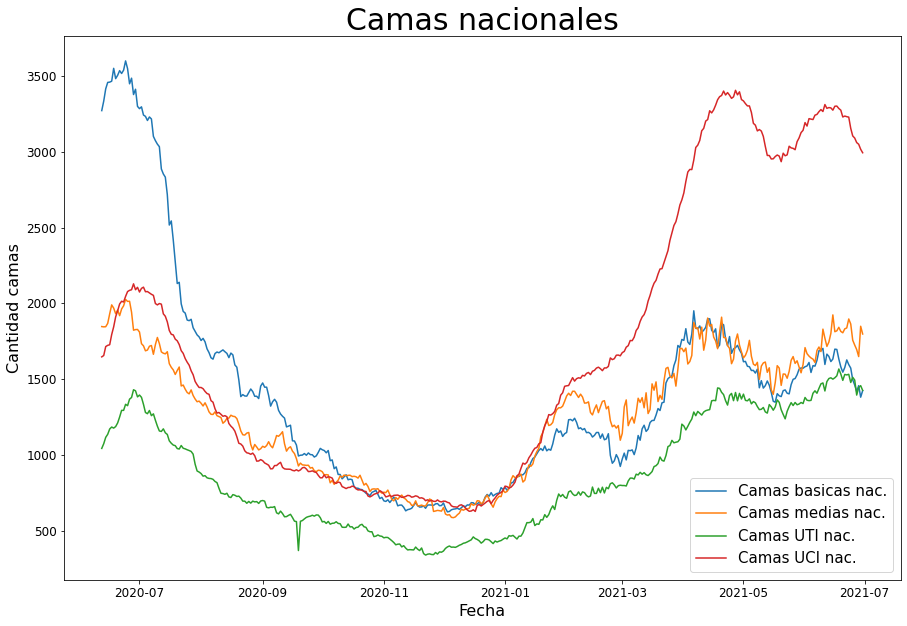

In [28]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data.iloc[:,[0,1,2,3]])
ax1.legend(('Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.',
       'Camas UCI nac.'), fontsize=15 , loc=4)
plt.title("Camas nacionales", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad camas", fontsize=16)

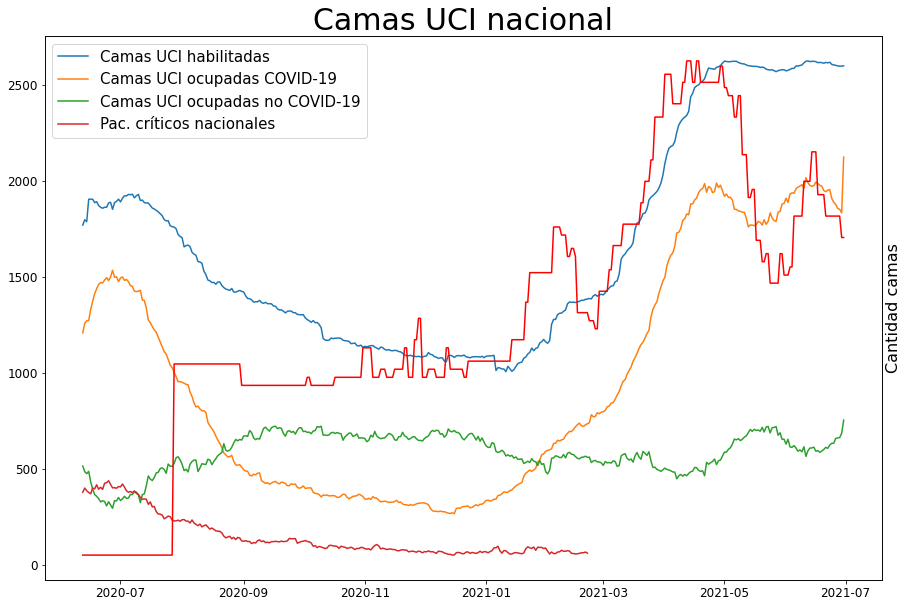

In [29]:
#ESTE
fig, ax2 = plt.subplots(1, 1)
plot = ax2.plot(data.iloc[:,[15,16,17,23]])
ax5 = ax2.twinx()
pasos_plot = ax5.plot(data.iloc[:,26], color="red")
ax5.set_yticks([1])
plt.ylabel("Paso a paso (% de encierro)", fontsize=16)
plot = plot + pasos_plot
plt.title("Camas UCI nacional", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad camas", fontsize=16)
ax2.legend(('Camas UCI habilitadas', 'Camas UCI ocupadas COVID-19', 'Camas UCI ocupadas no COVID-19', 'Pac. críticos nacionales', 'Porcentaje de encierro'), fontsize=15)

Text(0, 0.5, 'Personas con comorbilidad')

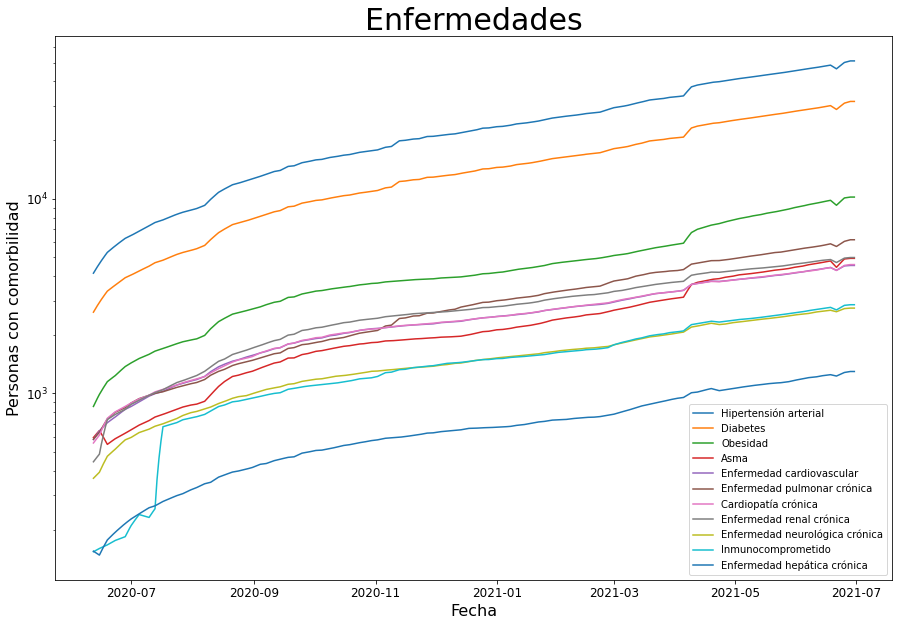

In [30]:
fig, ax3 = plt.subplots(1, 1)
ax3.plot(data.iloc[:,[4,5,6,7,8,9,10,11,12,13,14]])
ax3.legend(('Hipertensión arterial', 'Diabetes', 'Obesidad',
       'Asma', 'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica','Inmunocomprometido',
       'Enfermedad hepática crónica'))
plt.yscale('log')
plt.title("Enfermedades", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Personas con comorbilidad", fontsize=16)

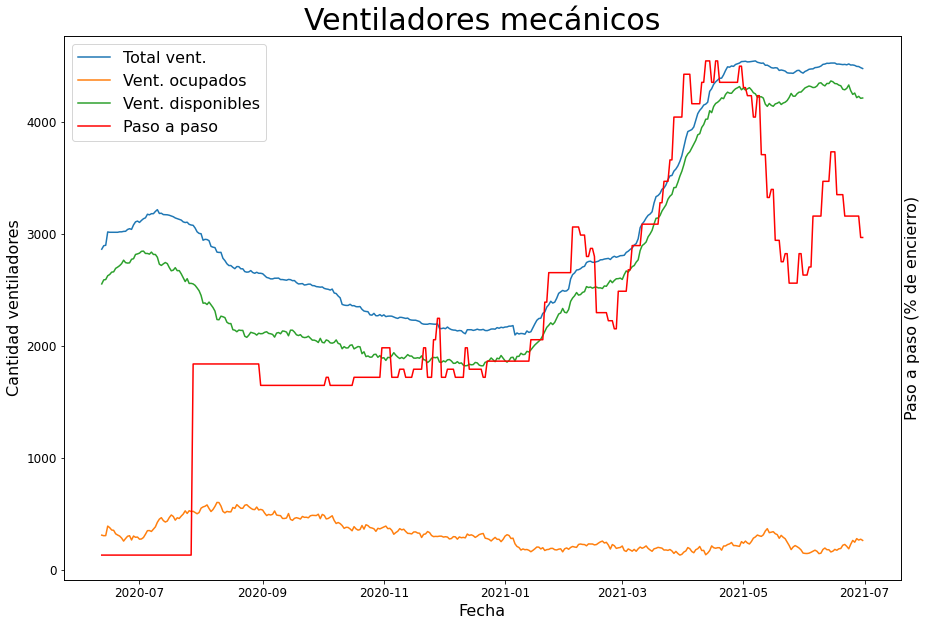

In [31]:
#ESTE
fig, ax4 = plt.subplots(1, 1)
ventiladores_plot = ax4.plot(data.iloc[:,[20,21,22]])
#ax4.legend(('Total vent.', 'Vent. ocupados',
       #'Vent. disponibles'), fontsize=15)
plt.title("Ventiladores mecánicos", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad ventiladores", fontsize=16)
ax5 = ax4.twinx()
pasos_plot = ax5.plot(data.iloc[:,26], color="red")
ax5.set_yticks([1])
plt.ylabel("Paso a paso (% de encierro)", fontsize=16)
#ax5.set_ytickslabels(("Paso 1", "Paso 2", "Paso 3", "Paso 4"))
plot = ventiladores_plot + pasos_plot
ax4.legend(plot, ["Total vent.", "Vent. ocupados", "Vent. disponibles", "Paso a paso"], fontsize=16)

Text(0, 0.5, 'Casos activos')

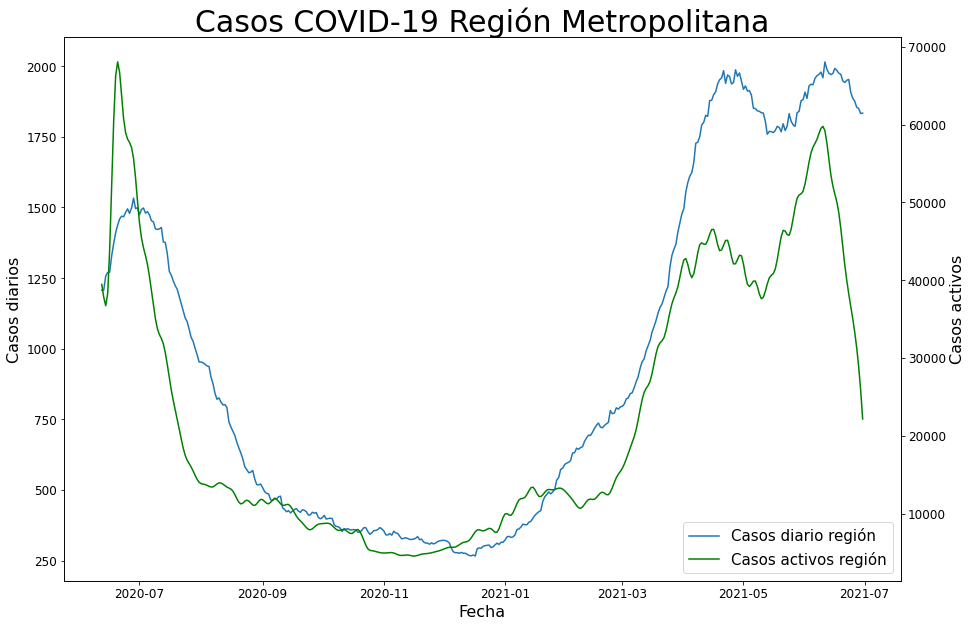

In [32]:
fig, ax5 = plt.subplots(1, 1)
diarios_plot = ax5.plot(data.iloc[:,24])
plt.title("Casos COVID-19 Región Metropolitana", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Casos diarios", fontsize=16)
ax6 = ax5.twinx()
activos_plot = ax6.plot(data.iloc[:,25], color="green")
plot = diarios_plot + activos_plot
ax5.legend(plot, ["Casos diario región", "Casos activos región"], fontsize=15, loc=4)
plt.ylabel("Casos activos", fontsize=16)

Text(0, 0.5, 'Cantidad ventiladores')

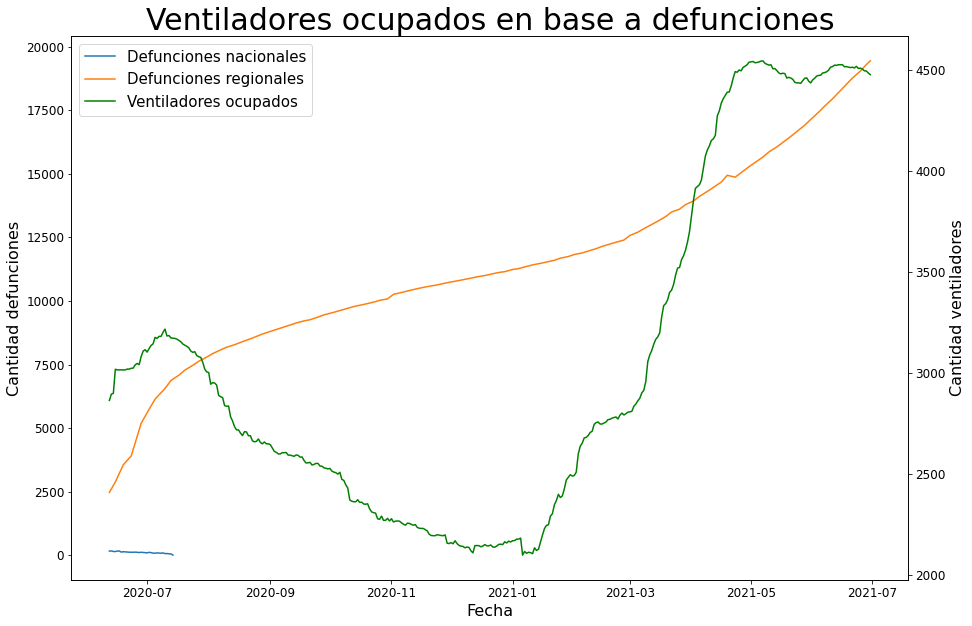

In [33]:
fig, ax7 = plt.subplots(1, 1)
defunciones_plot = ax7.plot(data.iloc[:,[18,19]])
#ax7.legend(('Defunciones', 'Vent. ocupados'), fontsize=15)
plt.title("Ventiladores ocupados en base a defunciones", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad defunciones", fontsize=16)
ax8 = ax7.twinx()
ventiladores_plot = ax8.plot(data.iloc[:,20], color="green")
plot = defunciones_plot + ventiladores_plot
ax8.legend(plot, ["Defunciones nacionales", "Defunciones regionales", "Ventiladores ocupados"], fontsize=15)
plt.ylabel("Cantidad ventiladores", fontsize=16)

## Limpieza de variables
### Se eliminan variables con datos faltantes incluso después de la interpolación.
Candidatos: 
 - Pacientes críticos
 - Defunciones nacional 

In [34]:
data = data.drop(labels=["Pac. criticos nacional", "Defunciones nacional"], axis=1)

Revisando que no queden datos faltantes

In [35]:
data.isnull().sum(axis=1)

2020-06-12    0
2020-06-13    0
2020-06-14    0
2020-06-15    0
2020-06-16    0
2020-06-17    0
2020-06-18    0
2020-06-19    0
2020-06-20    0
2020-06-21    0
2020-06-22    0
2020-06-23    0
2020-06-24    0
2020-06-25    0
2020-06-26    0
2020-06-27    0
2020-06-28    0
2020-06-29    0
2020-06-30    0
2020-07-01    0
2020-07-02    0
2020-07-03    0
2020-07-04    0
2020-07-05    0
2020-07-06    0
2020-07-07    0
2020-07-08    0
2020-07-09    0
2020-07-10    0
2020-07-11    0
2020-07-12    0
2020-07-13    0
2020-07-14    0
2020-07-15    0
2020-07-16    0
2020-07-17    0
2020-07-18    0
2020-07-19    0
2020-07-20    0
2020-07-21    0
2020-07-22    0
2020-07-23    0
2020-07-24    0
2020-07-25    0
2020-07-26    0
2020-07-27    0
2020-07-28    0
2020-07-29    0
2020-07-30    0
2020-07-31    0
2020-08-01    0
2020-08-02    0
2020-08-03    0
2020-08-04    0
2020-08-05    0
2020-08-06    0
2020-08-07    0
2020-08-08    0
2020-08-09    0
2020-08-10    0
2020-08-11    0
2020-08-12    0
2020-08-

## Visualización y análisis de correlación

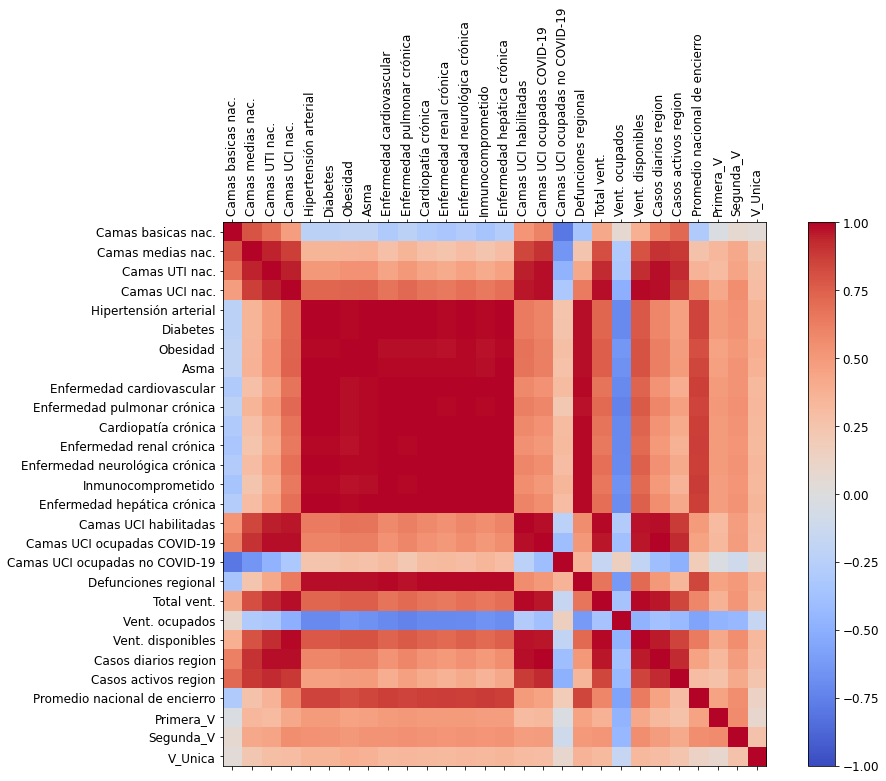

In [36]:
corr = data.corr(method="pearson")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [37]:
corr

,Camas basicas nac.,Camas medias nac.,Camas UTI nac.,Camas UCI nac.,Hipertensión arterial,Diabetes,Obesidad,Asma,Enfermedad cardiovascular,Enfermedad pulmonar crónica,...,Defunciones regional,Total vent.,Vent. ocupados,Vent. disponibles,Casos diarios region,Casos activos region,Promedio nacional de encierro,Primera_V,Segunda_V,V_Unica
Camas basicas nac.,1.000000,0.794989,0.691557,0.473381,-0.224191,-0.223546,-0.201194,-0.202001,-0.300963,-0.220249,...,-0.344792,0.415443,0.061681,0.382552,0.610986,0.712323,-0.292721,-0.025949,0.067824,0.037738
Camas medias nac.,0.794989,1.000000,0.944689,0.864451,0.346805,0.347294,0.358681,0.364988,0.277774,0.351502,...,0.235527,0.807464,-0.302399,0.802827,0.902638,0.884021,0.261939,0.334687,0.419179,0.220081
Camas UTI nac.,0.691557,0.944689,1.000000,0.948444,0.507118,0.507799,0.535813,0.532821,0.438682,0.501793,...,0.414629,0.927399,-0.324469,0.918865,0.982511,0.925610,0.354779,0.307477,0.443427,0.285960
Camas UCI nac.,0.473381,0.864451,0.948444,1.000000,0.722160,0.722135,0.733443,0.739929,0.669690,0.718561,...,0.637939,0.976976,-0.492257,0.989109,0.978411,0.885783,0.603744,0.414260,0.549237,0.290420
Hipertensión arterial,-0.224191,0.346805,0.507118,0.722160,1.000000,0.999986,0.991389,0.996639,0.995674,0.997801,...,0.980785,0.721630,-0.704845,0.778505,0.593025,0.464626,0.845865,0.485971,0.532652,0.346728
Diabetes,-0.223546,0.347294,0.507799,0.722135,0.999986,1.000000,0.991880,0.996820,0.995482,0.997624,...,0.980932,0.722067,-0.703572,0.778738,0.593348,0.465068,0.844212,0.485314,0.530829,0.348273
Obesidad,-0.201194,0.358681,0.535813,0.733443,0.991389,0.991880,1.000000,0.997323,0.983399,0.981698,...,0.979335,0.753303,-0.637573,0.798885,0.618613,0.483347,0.809968,0.446677,0.505629,0.386069
Asma,-0.202001,0.364988,0.532821,0.739929,0.996639,0.996820,0.997323,1.000000,0.990460,0.989542,...,0.977633,0.750855,-0.666967,0.800708,0.618156,0.485928,0.837365,0.468255,0.526830,0.360075
Enfermedad cardiovascular,-0.300963,0.277774,0.438682,0.669690,0.995674,0.995482,0.983399,0.990460,1.000000,0.993713,...,0.986601,0.670252,-0.704160,0.730028,0.528850,0.397792,0.864647,0.485744,0.525501,0.326338
Enfermedad pulmonar crónica,-0.220249,0.351502,0.501793,0.718561,0.997801,0.997624,0.981698,0.989542,0.993713,1.000000,...,0.975332,0.706779,-0.736822,0.769010,0.585831,0.462737,0.847596,0.505514,0.542071,0.335825


## Preparación de los datos

### Pacientes críticos acumulados a diarios

In [38]:
defunc_ix = list(data.columns).index("Defunciones regional")

In [39]:
from sklearn.preprocessing import MinMaxScaler
X = data.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=data.columns, index=data.index)

ind = int(X.shape[0]*0.7)
ind_name = data.index[ind]
ind_name_nxt = data.index[ind+1]
#y_index = list(data.columns).index("Camas UCI ocupadas COVID-19")

y_lab = "Camas UCI nac."

X_train = X.loc[:ind_name, X.columns != y_lab]
X_test = X.loc[ind_name_nxt:, X.columns != y_lab]
y_train = X.loc[:ind_name, "Camas UCI nac."]
y_test = X.loc[ind_name_nxt:, "Camas UCI nac."]

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
#from sklearn.preprocessing import StandardScaler

#defunc_ix, bedrooms_ix, population_ix, household_ix = [
#    list(housing.columns).index(col)
#    for col in ("total_rooms", "total_bedrooms", "population", "households")]
defunc_ix = list(X_train.columns).index("Defunciones regional")
# = data.iloc[:, defunc_ix]
class DataFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def acum_to_daily(self, X, y=None):
        temp_defunc = X[:, defunc_ix]
        defunc_diario = [temp_defunc[i] - temp_defunc[i-1] for i in range(X.shape[0]-1,0,-1)]
        defunc_diario = np.flip(defunc_diario).tolist()
        defunc_diario[0] = 0
        defunc_diario.append(temp_defunc[X.shape[0]-1])
        X[:,defunc_ix] = defunc_diario
        return X
        #return np.c_[X, defunc_diario]
    def scale_data(self, X, y=None):
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(X)
        return data_scaled

formatter = DataFormatter()


In [41]:
data_prec_train = formatter.acum_to_daily(X_train.values)
data_prec_test = formatter.acum_to_daily(X_test.values)

In [42]:
#data_prec_train_norm = formatter.scale_data(data_prec_train)
#data_prec_test_norm = formatter.scale_data(data_prec_test)

In [43]:
x_train = pd.DataFrame(
    data=data_prec_train,
    columns=list(X_train.columns),
    index=X_train.index)

x_test = pd.DataFrame(
    data=data_prec_test,
    columns=list(X_test.columns),
    index=X_test.index)

In [44]:
x_train.shape

(269, 27)

In [45]:
y_train.shape

(269,)

## Eliminación de variables por importancia

In [46]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:43:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Attribute,Importance
21,Casos diarios region,0.077255
15,Camas UCI ocupadas COVID-19,0.073420
18,Total vent.,0.072792
23,Promedio nacional de encierro,0.072244
22,Casos activos region,0.071426
0,Camas basicas nac.,0.071327
2,Camas UTI nac.,0.069788
1,Camas medias nac.,0.064943
16,Camas UCI ocupadas no COVID-19,0.064323
17,Defunciones regional,0.062686


In [47]:
#ESTE
x_train2 = x_train.drop(["Segunda_V", "Enfermedad hepática crónica", "Enfermedad neurológica crónica","Enfermedad renal crónica","Cardiopatía crónica","Enfermedad pulmonar crónica","Enfermedad cardiovascular","Asma","Obesidad","Diabetes","V_Unica", "Inmunocomprometido"], axis=1)
x_test2 = x_test.drop(["Segunda_V", "Enfermedad hepática crónica", "Enfermedad neurológica crónica","Enfermedad renal crónica","Cardiopatía crónica","Enfermedad pulmonar crónica","Enfermedad cardiovascular","Asma","Obesidad","Diabetes","V_Unica", "Inmunocomprometido"], axis=1)

In [48]:
model.fit(x_train2, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train2.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:43:16] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Attribute,Importance
11,Casos diarios region,0.077798
5,Camas UCI ocupadas COVID-19,0.073936
8,Total vent.,0.073162
13,Promedio nacional de encierro,0.072751
12,Casos activos region,0.071929
0,Camas basicas nac.,0.070870
2,Camas UTI nac.,0.070278
1,Camas medias nac.,0.065398
6,Camas UCI ocupadas no COVID-19,0.064776
3,Hipertensión arterial,0.062904


In [49]:
# Hacer plot de importancia

## Eliminar variables correlacionadas

In [50]:
corr = x_train2.corr(method="pearson")
corr

,Camas basicas nac.,Camas medias nac.,Camas UTI nac.,Hipertensión arterial,Camas UCI habilitadas,Camas UCI ocupadas COVID-19,Camas UCI ocupadas no COVID-19,Defunciones regional,Total vent.,Vent. ocupados,Vent. disponibles,Casos diarios region,Casos activos region,Promedio nacional de encierro,Primera_V
Camas basicas nac.,1.000000,0.912555,0.938480,-0.748079,0.917544,0.947316,-0.862420,0.031063,0.825606,0.181586,0.806740,0.944366,0.936553,-0.780106,-0.086456
Camas medias nac.,0.912555,1.000000,0.958650,-0.521098,0.883072,0.940987,-0.897748,0.067066,0.892982,0.044567,0.930066,0.938467,0.858551,-0.527571,0.167446
Camas UTI nac.,0.938480,0.958650,1.000000,-0.603769,0.941061,0.980419,-0.901898,0.086499,0.925497,0.113761,0.938348,0.980517,0.880278,-0.644668,0.079262
Hipertensión arterial,-0.748079,-0.521098,-0.603769,1.000000,-0.761066,-0.617452,0.417413,0.070619,-0.611303,-0.711411,-0.378885,-0.622346,-0.576572,0.824015,0.436371
Camas UCI habilitadas,0.917544,0.883072,0.941061,-0.761066,1.000000,0.949125,-0.780109,0.073584,0.963001,0.381766,0.876645,0.952376,0.792866,-0.716272,-0.002594
Camas UCI ocupadas COVID-19,0.947316,0.940987,0.980419,-0.617452,0.949125,1.000000,-0.924593,0.091076,0.913960,0.099350,0.931570,0.999350,0.890389,-0.683849,0.064089
Camas UCI ocupadas no COVID-19,-0.862420,-0.897748,-0.901898,0.417413,-0.780109,-0.924593,1.000000,-0.077783,-0.758394,0.129546,-0.853268,-0.921649,-0.862527,0.531888,-0.084098
Defunciones regional,0.031063,0.067066,0.086499,0.070619,0.073584,0.091076,-0.077783,1.000000,0.101492,-0.088133,0.140993,0.089786,0.081489,0.053777,-0.022888
Total vent.,0.825606,0.892982,0.925497,-0.611303,0.963001,0.913960,-0.758394,0.101492,1.000000,0.333568,0.934129,0.918941,0.695690,-0.536860,0.152251
Vent. ocupados,0.181586,0.044567,0.113761,-0.711411,0.381766,0.099350,0.129546,-0.088133,0.333568,1.000000,-0.024898,0.112883,-0.062278,-0.332271,-0.352940


In [51]:

cor_matrix = corr.abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#upper_tri.iloc[4,:] > 0.90
#print(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(to_drop)

#data_dropped = x_train.copy()
#data_dropped = data_dropped.drop(to_drop, axis=1)

['Camas medias nac.', 'Camas UTI nac.', 'Camas UCI habilitadas', 'Camas UCI ocupadas COVID-19', 'Camas UCI ocupadas no COVID-19', 'Total vent.', 'Vent. disponibles', 'Casos diarios region', 'Casos activos region']


<ipython-input-51-e18e441e33a4>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [52]:
#ESTE
i=0
j=0
corrList = []
corr2 = corr.index[np.where((corr.iloc[:,0] >= 0.90) & (corr.iloc[:,0] != 1))]
while(i < len(corr.columns)):
    while(j < len(corr2)):
        corrList.append(corr.index[np.where((corr.iloc[:,0] >= 0.90) & (corr.iloc[:,0] != 1))][j])
        j=j+1
    
    x_train2 = x_train2.drop(corrList, axis=1)
    x_test2 = x_test2.drop(corrList, axis=1)
    corr = x_train2.corr(method="pearson")
    i=i+1
    j=0
    corrList = []
    corr2 = corr.index[np.where((corr.iloc[:,0] >= 0.90) & (corr.iloc[:,0] != 1))]

    

In [53]:
#ESTE
x_train3 = x_train2
x_test3 = x_test2
corr = x_train3.corr(method="pearson")
corr

#### ¿POR QUÉ NO SE ELIMINA HIPERTENSIÓN ARTERIAL/INMUNOCOMPROMETIDO Y VENT.DISP/TOTAL.VENT#####

,Camas basicas nac.,Hipertensión arterial,Camas UCI ocupadas no COVID-19,Defunciones regional,Total vent.,Vent. ocupados,Vent. disponibles,Promedio nacional de encierro,Primera_V
Camas basicas nac.,1.000000,-0.748079,-0.862420,0.031063,0.825606,0.181586,0.806740,-0.780106,-0.086456
Hipertensión arterial,-0.748079,1.000000,0.417413,0.070619,-0.611303,-0.711411,-0.378885,0.824015,0.436371
Camas UCI ocupadas no COVID-19,-0.862420,0.417413,1.000000,-0.077783,-0.758394,0.129546,-0.853268,0.531888,-0.084098
Defunciones regional,0.031063,0.070619,-0.077783,1.000000,0.101492,-0.088133,0.140993,0.053777,-0.022888
Total vent.,0.825606,-0.611303,-0.758394,0.101492,1.000000,0.333568,0.934129,-0.536860,0.152251
Vent. ocupados,0.181586,-0.711411,0.129546,-0.088133,0.333568,1.000000,-0.024898,-0.332271,-0.352940
Vent. disponibles,0.806740,-0.378885,-0.853268,0.140993,0.934129,-0.024898,1.000000,-0.443494,0.295081
Promedio nacional de encierro,-0.780106,0.824015,0.531888,0.053777,-0.536860,-0.332271,-0.443494,1.000000,0.391691
Primera_V,-0.086456,0.436371,-0.084098,-0.022888,0.152251,-0.352940,0.295081,0.391691,1.000000


In [54]:
#x_train3 = x_train2.drop(["Hipertensión arterial", "Camas UTI nac.", "Camas UCI ocupadas COVID-19", "Camas UCI habilitadas", 'Camas medias nac.', 'Vent. disponibles', 'Casos activos region'], axis=1)
#x_test3 = x_test2.drop(["Hipertensión arterial", "Camas UTI nac.", "Camas UCI ocupadas COVID-19", "Camas UCI habilitadas", 'Camas medias nac.', 'Vent. disponibles', 'Casos activos region'], axis=1)
#corr = x_train3.corr(method="pearson")
#corr
#to_drop = x_train[["Enfermedad renal crónica", "Camas UCI nac.", ]]

In [55]:
model.fit(x_train3, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train3.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

C:\ProgramData\Miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:43:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Attribute,Importance
7,Promedio nacional de encierro,0.127506
0,Camas basicas nac.,0.124476
4,Total vent.,0.115727
2,Camas UCI ocupadas no COVID-19,0.111579
6,Vent. disponibles,0.111440
1,Hipertensión arterial,0.109665
5,Vent. ocupados,0.104558
3,Defunciones regional,0.100644
8,Primera_V,0.094406


In [56]:
x_train = x_train3.copy()
x_test = x_test3.copy()

In [57]:
x_train = pd.merge(x_train, y_train, how='outer',left_index=True, right_index=True)
x_test = pd.merge(x_test, y_test, how='outer',left_index=True, right_index=True)

In [58]:
#x_train = x_train[["Casos diarios region", "Camas UCI nac."]]

In [59]:
x_train.head()

,Camas basicas nac.,Hipertensión arterial,Camas UCI ocupadas no COVID-19,Defunciones regional,Total vent.,Vent. ocupados,Vent. disponibles,Promedio nacional de encierro,Primera_V,Camas UCI nac.
2020-06-12,0.889785,0.000000,0.479643,0.000000,0.313036,0.378723,0.287456,0.0,0.0,0.367039
2020-06-13,0.910954,0.003514,0.414237,0.008074,0.325705,0.368085,0.301612,0.0,0.0,0.370277
2020-06-14,0.938172,0.007029,0.392435,0.008074,0.327340,0.370213,0.302792,0.0,0.0,0.391508
2020-06-15,0.952285,0.010543,0.418598,0.009931,0.375971,0.551064,0.316162,0.0,0.0,0.394386
2020-06-16,0.952957,0.014070,0.298687,0.009931,0.374745,0.521277,0.320488,0.0,0.0,0.395826


In [60]:
#x_test = x_test[["Casos diarios region", "Camas UCI nac."]]

- To do: sintonización de selección de variables

# Modelación

In [61]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from sklearn.metrics import mean_squared_error        
from sklearn.metrics import mean_absolute_error
from copy import deepcopy

In [62]:
#from sklearn.model_selection import TimeSeriesSplit

#test_size = round(0.25*data.shape[0])
#print(test_size)
#data_x = data.drop("Camas UCI ocupadas COVID-19", axis=1)
#data_y = data["Camas UCI ocupadas COVID-19"].copy()
#split = TimeSeriesSplit(data_x, data_y, test_size=test_size)
#for train_index, test_index in TimeSeriesSplit.split(data_x):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

In [63]:
#data = strat_train_set.drop("Camas UCI ocupadas COVID-19", axis=1)
#uci = strat_train_set["Camas UCI ocupadas COVID-19"].copy()

In [64]:
x_train_temp = deepcopy(x_train)
x_test_temp = deepcopy(x_test)
y_train_temp = deepcopy(y_train)
y_test_temp = deepcopy(y_test)

### Función de retrasos

In [65]:
# Function to create the data set
# Equation f(yt) = f(yt-1)
# convert an array of values into a dataset matrix
def create_dataset(name, dataset, look_back=1):
    dataX, dataY = [], []
    names = [(name + "_t-" + str(i)) for i in range(look_back)]
    names.reverse()
    dt = dataset.values
    for i in range(len(dt)-look_back-1):
        a = dt[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dt[i + look_back])
    indices = dataset.index[(look_back+1):]
    dataset_ret = pd.DataFrame(dataX, columns=names, index=indices)
    return dataset_ret#np.array(dataX), np.array(dataY)

In [66]:
# Insertar retardos en dataset
def insert_lags(data, lags):
    dt = pd.DataFrame()
    for col in data.columns:
        var = data[col]
        var_ret = create_dataset(col, var, lags)
        selected_cols = var_ret.columns[:-1] # Remove Xt-0
        var_ret = var_ret[selected_cols]
        dt[selected_cols] = var_ret
    dataframe = pd.DataFrame(dt)
    return dataframe

In [67]:
def lags_preparation(x_train,x_test,y_train,y_test, lags):
    
    # Insertar retardos en variables x
    x_train = insert_lags(x_train, lags)
    x_test = insert_lags(x_test, lags)
    
    # Insertar retardos en variables y
    y_lab = y_test.name
    y_lab_t0 = y_lab + "_t-0"
    y_train = create_dataset(y_lab, y_train, lags)
    y_train = y_train[[y_lab_t0]]
    y_test = create_dataset(y_lab, y_test, lags)
    y_test = y_test[[y_lab_t0]]
    return(x_train, x_test, y_train, y_test)

In [68]:
#x_train = insert_lags(x_train, look_back)
#x_test = insert_lags(x_test, look_back)

In [69]:
# Insertar retardos en variables y
#y_lab_t0 = y_lab + "_t-0"

#y_train = create_dataset(y_lab, y_train, look_back)
#y_train = y_train[[y_lab_t0]]
#y_test = create_dataset(y_lab, y_test, look_back)
#y_test = y_test[[y_lab_t0]]

In [70]:
# Insertar retardos en dataset de features test
#dt_test = pd.DataFrame()
#for col in x_test.columns:
#    var = x_test[col]
#    var_ret = create_dataset(col, var, look_back)
#    selected_cols = var_ret.columns[:-1] # Remove Xt-0
#    var_ret = var_ret[selected_cols]
#    dt_test[selected_cols] = var_ret
#x_test = pd.DataFrame(dt_test)

In [71]:
x_train_temp = x_train
x_test_temp = x_test

y_train_temp = y_train
y_test_temp = y_test

## Modelo de regresión lineal

In [72]:
#import sys
#!{sys.executable} -m pip install sklearn

In [78]:
look_back = 5 # Esto se debe cambiar al hacer tuning

In [79]:
train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, look_back)

In [80]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
params = lin_reg.get_params()

lin_reg.fit(train_x, train_y)

LinearRegression()

In [81]:
params

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [82]:
linear_predct = lin_reg.predict(test_x)
linear_predct = linear_predct[:,0]
print("Predictions:", linear_predct)

Predictions: [0.47277521 0.47570106 0.48906239 0.51643612 0.53076286 0.54281537
 0.54837913 0.56031261 0.57595329 0.58636419 0.58727687 0.60505496
 0.62068083 0.63060984 0.66202016 0.68354983 0.69701425 0.71046666
 0.72987115 0.74565239 0.75815717 0.77197565 0.80546024 0.82410588
 0.83335941 0.83960289 0.84685993 0.88788145 0.89133261 0.89957951
 0.92995087 0.92694749 0.95314632 0.94865285 0.96956845 0.96036327
 0.97136931 0.98244133 0.9967959  1.00516158 1.0120385  1.01358418
 0.99430505 1.00883121 1.00272207 0.99539898 1.00073414 1.02112068
 1.00874157 1.01188248 0.98702207 0.98477537 0.97997502 0.97862186
 0.97690658 0.95733513 0.93050854 0.92691146 0.91233835 0.92127397
 0.92460247 0.90303226 0.87555342 0.85568258 0.8563235  0.8508395
 0.8523192  0.86636437 0.86463546 0.8651583  0.84405123 0.86749182
 0.86071861 0.86675236 0.89638498 0.88581473 0.87876232 0.87137266
 0.9024875  0.90569459 0.92860592 0.9329637  0.94770785 0.93396301
 0.95793637 0.95209194 0.94823732 0.96089756 0.970

In [83]:
linear_predct = pd.Series(linear_predct)
linear_predct.index = test_x.index

#print(y_test)
#print(linear_predct.index)

data_linear = pd.concat([test_y, linear_predct], axis=1)

lin_corr = test_y.iloc[:,0].corr(linear_predct)
lin_corr

0.9966056911094827

In [84]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(test_y, linear_predct)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.019113148265627874

In [85]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(test_y, linear_predct)
lin_mae

0.015340186797330048

Text(0, 0.5, 'UCI ocupadas')

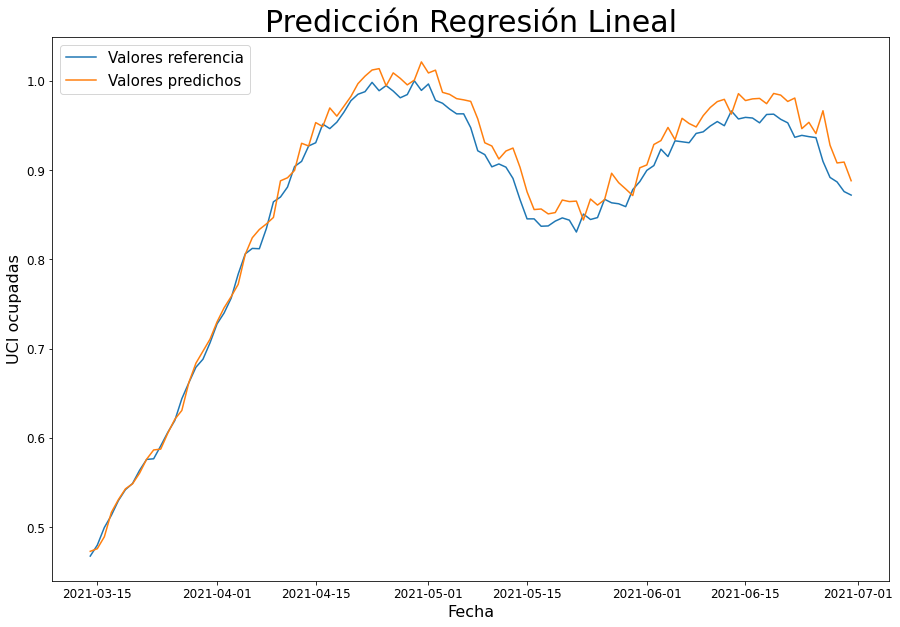

In [86]:
fig, ax4 = plt.subplots(1, 1)
ax4.plot(data_linear)
ax4.legend(('Valores referencia', 'Valores predichos'), fontsize=15)
plt.title("Predicción Regresión Lineal", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("UCI ocupadas", fontsize=16)

## Multilayer Perceptron model

### Parameter Tuning

In [87]:
def tune_multilayer_NN(x_train, x_test, y_train, y_test,lags=[2,3,4],
                       layer1=[4,5,6], layer2=[2,3,4],layer3=None, 
                       epochs=50, activation=['relu'], optimizer=['adam'], batches=2, verbose=True):
    a = [lags, layer1, layer2, activation, optimizer]
    comb_n = len(list(itertools.product(*a)))
    performances = np.zeros((comb_n,5))
    combinations = np.empty((comb_n,6), dtype='<U32')
    i = 0
    np.seterr(divide='ignore', invalid='ignore')
    for comb in itertools.product(*a):
        lag = comb[0]
        layer1 = comb[1]
        layer2 = comb[2]
        activation = comb[3]
        optimizer = comb[4]
        combinations[i, :] = np.array([i, lag, layer1, layer2, activation, optimizer])
        if verbose:
            print("Testing combination " + str(i) + ": " + str(comb))
        else:
            print("Progress: " + str(i) + "/" + str(comb_n))
        # Add lags in dataset
        train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, lag)
        
        # Create and fit Multilayer Perceptron model
        model = Sequential()
        model.add(Dense(layer1, input_dim=train_x.shape[1], activation=activation))
        model.add(Dense(layer2, activation=activation))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        model.fit(train_x, train_y, shuffle=False, epochs=epochs, batch_size=batches, verbose=False)
        
        # Estimate model performance
        trainScore = model.evaluate(train_x, train_y, verbose=0)
        #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, sqrt(trainScore)))
        testScore = model.evaluate(test_x, test_y, verbose=0)
        #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, sqrt(testScore)))
        
        # Generate predictions for training
        trainPredict = model.predict(train_x)
        testPredict = model.predict(test_x)

        # Calculate train correlation
        train_corr = np.corrcoef(train_y.values[:,0], trainPredict[:,0])
        train_corr = train_corr[0,1]
        
        # Calculate test correlation
        test_corr = np.corrcoef(test_y.values[:,0], testPredict[:,0])
        test_corr = test_corr[0,1]
        
        performances[i,:] = np.array([i, trainScore, train_corr, testScore, test_corr])
        if verbose:
            print("Performances: " + str(performances[i,:]))
        i = i+1
    
    np.seterr(divide='warn', invalid='warn')    
    
    performances_sorted = performances[np.argsort(performances[:, 3])]
    performances_df = pd.DataFrame(performances_sorted, columns=['id','Train RMSE','Train correlation', 'Test RMSE','Test correlation'])
    
    ordered_index = [int(x) for x in performances_sorted[:,0]]
    performances_df.index = ordered_index
    performances_df.drop('id', axis=1,inplace=True)
    
    combinations_sorted = combinations[ordered_index]
    combinations_df = pd.DataFrame(combinations_sorted, columns=['id','Lags', 'Nodes layer 1', 'Nodes layer 2', 'Activation Function', 'Optimizer Function'])
    combinations_df.index = ordered_index
    combinations_df.drop('id', axis=1,inplace=True)
    
    return(combinations_df, performances_df)

In [88]:
import itertools

lags_range = [2,3,4,5]
layer1_range = [4, 6]#, 8, 10, 12]
layer2_range = [4, 6]#, 8, 10, 12]
layer3_range = []
activations = ['relu']
optimizers = ['adam']
tuning_epochs=1
batch=10

In [89]:
# Number of combinations
i = 0
combs = [lags_range, layer1_range, layer2_range, activations, optimizers]
for comb in itertools.product(*combs):
    #print(np.array(comb).shape)
    i = i+1
print(str(i*tuning_epochs) + " combinaciones")

16 combinaciones


In [90]:
parameters, performances = tune_multilayer_NN(x_train, x_test, y_train, y_test, lags=lags_range, 
                   layer1=layer1_range, layer2=layer2_range, 
                   epochs=tuning_epochs, activation=activations, optimizer=optimizers, batches=batch, verbose=False)

Progress: 0/16
Progress: 1/16
Progress: 2/16
Progress: 3/16
Progress: 4/16
Progress: 5/16
Progress: 6/16
Progress: 7/16
Progress: 8/16
Progress: 9/16
Progress: 10/16
Progress: 11/16
Progress: 12/16
Progress: 13/16
Progress: 14/16
Progress: 15/16


In [91]:
best_performance = performances.iloc[0,:]
best_performance

Train RMSE           0.051492
Train correlation   -0.002244
Test RMSE            0.009381
Test correlation     0.911630
Name: 10, dtype: float64

In [92]:
best_model = parameters.iloc[0,:]
best_model

Lags                      4
Nodes layer 1             6
Nodes layer 2             4
Activation Function    relu
Optimizer Function     adam
Name: 10, dtype: object

### Tuned Multilayer Perceptron results

In [93]:
# create and fit Multilayer Perceptron model
epochs = 500
look_back = int(best_model['Lags'])

train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, look_back )

In [94]:
model = Sequential()
model.add(Dense(int(best_model['Nodes layer 1']), input_dim=train_x.shape[1], activation=best_model['Activation Function']))
model.add(Dense(int(best_model['Nodes layer 2']), activation=best_model['Activation Function']))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=best_model['Optimizer Function'])
model.fit(train_x, train_y, shuffle=False, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
264/264 - 0s - loss: 0.0455
Epoch 2/100
264/264 - 0s - loss: 0.0126
Epoch 3/100
264/264 - 0s - loss: 0.0063
Epoch 4/100
264/264 - 0s - loss: 0.0052
Epoch 5/100
264/264 - 0s - loss: 0.0044
Epoch 6/100
264/264 - 0s - loss: 0.0034
Epoch 7/100
264/264 - 0s - loss: 0.0021
Epoch 8/100
264/264 - 0s - loss: 0.0013
Epoch 9/100
264/264 - 0s - loss: 9.5654e-04
Epoch 10/100
264/264 - 0s - loss: 7.4053e-04
Epoch 11/100
264/264 - 0s - loss: 6.0819e-04
Epoch 12/100
264/264 - 0s - loss: 5.4088e-04
Epoch 13/100
264/264 - 0s - loss: 5.2622e-04
Epoch 14/100
264/264 - 0s - loss: 5.2910e-04
Epoch 15/100
264/264 - 0s - loss: 4.9865e-04
Epoch 16/100
264/264 - 0s - loss: 4.4422e-04
Epoch 17/100
264/264 - 0s - loss: 4.2118e-04
Epoch 18/100
264/264 - 0s - loss: 3.7166e-04
Epoch 19/100
264/264 - 0s - loss: 3.4862e-04
Epoch 20/100
264/264 - 0s - loss: 2.9383e-04
Epoch 21/100
264/264 - 0s - loss: 3.0395e-04
Epoch 22/100
264/264 - 0s - loss: 2.5862e-04
Epoch 23/100
264/264 - 0s - loss: 2.6646e-04
Epoch 

In [95]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 6)                 186       
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 5         
Total params: 219
Trainable params: 219
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Estimate model performance
trainScore = model.evaluate(train_x, train_y, verbose=0)
print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore, sqrt(trainScore)))
testScore = model.evaluate(test_x, test_y, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, sqrt(testScore)))

Train Score: 0.0010 MSE (0.0324 RMSE)
Test Score: 0.1515 MSE (0.3892 RMSE)


In [97]:
# Generate predictions for training
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

In [98]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data[[y_lab]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [99]:
# Shift test predictions for plotting
testPredictPlot = np.empty_like(data[[y_lab]])
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

In [100]:
trainPredictPlot = pd.DataFrame(trainPredictPlot, index=data.index)
testPredictPlot = pd.DataFrame(testPredictPlot, index=data.index)

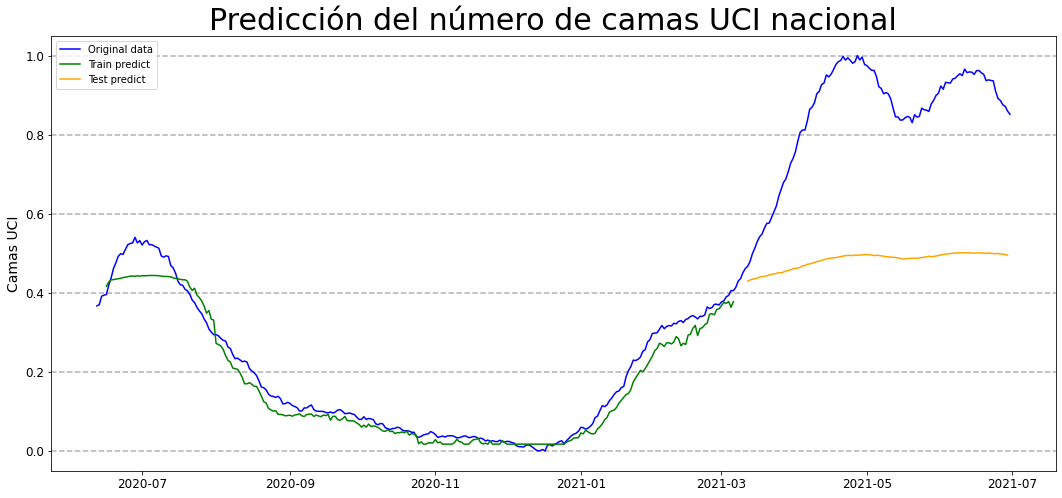

In [101]:
# Plot original data and predictions
fig, ax = plt.subplots(figsize=(18,8)) # Tamaño del gráfico
plt.plot(X[[y_lab]], color="blue", label="Original data")

#Título del gráfico
ax.set_title('Predicción del número de camas UCI nacional', fontsize=30)

# Define del eje y
ax.set_ylabel('Camas UCI')
plt.grid(True, 'major', 'y', ls='--', lw=1.5, c='k', alpha=.3)

#Define el eje x
plt.tick_params(axis='x', which='major', labelsize=12)

#plt.axis([0, 155,0,650])

plt.plot(trainPredictPlot, color="green", label="Train predict")
plt.plot(testPredictPlot, color="orange", label="Test predict")
ax.legend(loc="upper left", title="")


plt.show()

# LSTM

### Parameter Tuning

In [102]:
def tune_LSTM_NN(x_train, x_test, y_train, y_test,lags=[2,3,4],
                       layer1=[4,5,6], layer2=[2,3,4],layer3=None, 
                       epochs=50, activation=['tanh'], optimizer=['adam'], batches=1, verbose=True):
    a = [lags, layer1, layer2, activation, optimizer]
    comb_n = len(list(itertools.product(*a)))
    performances = np.zeros((comb_n,5))
    combinations = np.empty((comb_n,6), dtype='<U32')
    i = 0
    np.seterr(divide='ignore', invalid='ignore')
    for comb in itertools.product(*a):
        lag = comb[0]
        layer1 = comb[1]
        layer2 = comb[2]
        activation = comb[3]
        optimizer = comb[4]
        combinations[i, :] = np.array([i, lag, layer1, layer2, activation, optimizer])
        if verbose:
            print("Testing combination " + str(i) + ": " + str(comb))
        else:
            print("Progress: " + str(i) + "/" + str(comb_n))
    
        # Add lags in dataset
        train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, lag)
        
        # reshape input to be [samples, time steps, features !=columnas]
        features = round(train_x.shape[1]/(lag-1))
        train_x_temp = np.reshape(train_x.values, (train_x.shape[0], features, lag-1))
        test_x_temp = np.reshape(test_x.values, (test_x.shape[0], features, lag-1))
        
        # Create and fit LSTM model
        look_forward = 1
        model = Sequential()
        model.add(LSTM(layer1, batch_input_shape=(batches, features, lag-1), activation=activation, stateful=True, return_sequences=True))
        model.add(LSTM(layer2, batch_input_shape=(batches, features, lag-1), activation=activation, stateful=True))
        model.add(Dense(look_forward))
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        for j in range(epochs):
            model.fit(train_x_temp, train_y.values, epochs=1, batch_size=batches, verbose=0, shuffle=False)
            model.reset_states()
                     
        # Generate predictions for training
        trainPredict = model.predict(train_x_temp, batch_size=batches)
        model.reset_states()
        testPredict = model.predict(test_x_temp, batch_size=batches)
        
        # Estimate model performance
        #trainScore = sqrt(mean_squared_error(train_y.values[:,0], trainPredict[:,0]))
        #testScore = sqrt(mean_squared_error(test_y.values[:,0], testPredict[:,0]))
        trainScore = model.evaluate(train_x_temp, train_y.values, batch_size=batches,verbose=0)
        testScore = model.evaluate(test_x_temp, test_y.values, batch_size=batches, verbose=0)
        
        # Calculate train correlation
        train_corr = np.corrcoef(train_y.values[:,0], trainPredict[:,0])
        train_corr = train_corr[0,1]
        
        # Calculate test correlation
        test_corr = np.corrcoef(test_y.values[:,0], testPredict[:,0])
        test_corr = test_corr[0,1]
        
        performances[i,:] = np.array([i, trainScore, train_corr, testScore, test_corr])
        if verbose:
            print("Performances: " + str(performances[i,:]))
        i = i+1
        
    np.seterr(divide='warn', invalid='warn')    
    
    performances_sorted = performances[np.argsort(performances[:, 3])]
    performances_df = pd.DataFrame(performances_sorted, columns=['id','Train RMSE','Train correlation', 'Test RMSE','Test correlation'])
    
    ordered_index = [int(x) for x in performances_sorted[:,0]]
    performances_df.index = ordered_index
    performances_df.drop('id', axis=1,inplace=True)
    
    combinations_sorted = combinations[ordered_index]
    combinations_df = pd.DataFrame(combinations_sorted, columns=['id','Lags', 'Nodes layer 1', 'Nodes layer 2', 'Activation Function', 'Optimizer Function'])
    combinations_df.index = ordered_index
    combinations_df.drop('id', axis=1,inplace=True)
    
    return(combinations_df, performances_df)

In [103]:
import itertools

# Tuning grid parameters

lags_range = [2,3,4,5]
layer1_range = [4, 6]#, 8, 10, 12]
layer2_range = [4, 6]#, 8, 10, 12]
layer3_range = []
activations = ['tanh']
optimizers = ['adam']
tuning_epochs=5
batch=1

In [104]:
# Number of combinations
i = 0
combs = [lags_range, layer1_range, layer2_range, activations, optimizers]
for comb in itertools.product(*combs):
    #print(np.array(comb).shape)
    i = i+1
print(str(i*tuning_epochs) + " combinaciones")

80 combinaciones


In [105]:
parameters_LSTM, performances_LSTM = tune_LSTM_NN(x_train, x_test, y_train, y_test, lags=lags_range, 
                   layer1=layer1_range, layer2=layer2_range, 
                   epochs=tuning_epochs, activation=activations, optimizer=optimizers, batches=batch, verbose=True)

Testing combination 0: (2, 4, 4, 'tanh', 'adam')
Performances: [0.         0.02609638 0.61039146 0.40487856 0.85397107]
Testing combination 1: (2, 4, 6, 'tanh', 'adam')
Performances: [1.         0.02786057 0.58689082 0.34058207 0.84140756]
Testing combination 2: (2, 6, 4, 'tanh', 'adam')
Performances: [2.         0.05467167 0.51201994 0.21644533 0.8249734 ]
Testing combination 3: (2, 6, 6, 'tanh', 'adam')
Performances: [3.         0.04234339 0.67981745 0.2730476  0.71443633]
Testing combination 4: (3, 4, 4, 'tanh', 'adam')
Performances: [4.         0.02525144 0.74484797 0.31768504 0.8242815 ]
Testing combination 5: (3, 4, 6, 'tanh', 'adam')
Performances: [5.         0.03510453 0.04324332 0.33930713 0.53128199]
Testing combination 6: (3, 6, 4, 'tanh', 'adam')
Performances: [6.         0.02617065 0.39346488 0.44074741 0.40102635]
Testing combination 7: (3, 6, 6, 'tanh', 'adam')
Performances: [7.         0.03668556 0.62608809 0.26474929 0.77196179]
Testing combination 8: (4, 4, 4, 'tanh',

In [106]:
performances_LSTM

,Train RMSE,Train correlation,Test RMSE,Test correlation
2,0.054672,0.512020,0.216445,0.824973
7,0.036686,0.626088,0.264749,0.771962
3,0.042343,0.679817,0.273048,0.714436
11,0.045659,0.651557,0.282879,0.011558
8,0.033268,0.707562,0.312256,0.444307
4,0.025251,0.744848,0.317685,0.824281
5,0.035105,0.043243,0.339307,0.531282
15,0.029869,0.666152,0.340108,0.701439
1,0.027861,0.586891,0.340582,0.841408
10,0.025051,0.704293,0.344613,0.778390


In [107]:
best_performance = performances_LSTM.iloc[0,:]
best_performance

Train RMSE           0.054672
Train correlation    0.512020
Test RMSE            0.216445
Test correlation     0.824973
Name: 2, dtype: float64

In [108]:
best_model = parameters_LSTM.iloc[0,:]
best_model

Lags                      2
Nodes layer 1             6
Nodes layer 2             4
Activation Function    tanh
Optimizer Function     adam
Name: 2, dtype: object

### Tuned LSTM results

In [109]:
x_train.shape

(269, 10)

In [110]:
look_back = int(best_model['Lags'])
epochs=500

train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, look_back)


In [111]:
def custom_reshape(X, lags):
    len_x = X.shape[0]
    len_y = X.shape[1]
    n_features = round(len_y/lags)
    x3d = np.zeros((len_x, lags, n_features))
    i = 0
    feature = 0
    while (i + lags <= len_y):
        x3d[:, :, feature] = X[:, i : i + lags]
        i += lags
        feature = feature + 1
    return x3d

In [112]:
features = round(train_x.shape[1]/(look_back-1))

x_train_temp = custom_reshape(X=train_x.values, lags=look_back-1)
x_test_temp = custom_reshape(X=test_x.values, lags=look_back-1)

#x_train_temp = np.reshape(train_x.values, (train_x.shape[0], features, look_back-1))
#x_test_temp = np.reshape(test_x.values, (test_x.shape[0], features, look_back-1))

In [113]:
# create and fit the LSTM network
batch_size = batch
look_forward = 1
model = Sequential()
model.add(LSTM(int(best_model['Nodes layer 1']), activation=best_model['Activation Function'], batch_input_shape=(batch_size, look_back-1, features), stateful=True, return_sequences=True))
model.add(LSTM(int(best_model['Nodes layer 2']), activation=best_model['Activation Function'], batch_input_shape=(batch_size, look_back-1, features), stateful=True))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer=best_model['Optimizer Function'])

In [114]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (1, 1, 6)                 408       
_________________________________________________________________
lstm_33 (LSTM)               (1, 4)                    176       
_________________________________________________________________
dense_67 (Dense)             (1, 1)                    5         
Total params: 589
Trainable params: 589
Non-trainable params: 0
_________________________________________________________________


In [115]:
for i in range(epochs):
    model.fit(x_train_temp, train_y.values, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

266/266 - 0s - loss: 0.0193
266/266 - 0s - loss: 0.0034
266/266 - 0s - loss: 0.0022
266/266 - 0s - loss: 0.0025
266/266 - 0s - loss: 0.0026
266/266 - 0s - loss: 0.0024
266/266 - 0s - loss: 0.0021
266/266 - 0s - loss: 0.0018
266/266 - 0s - loss: 0.0015
266/266 - 0s - loss: 0.0013
266/266 - 0s - loss: 0.0011
266/266 - 0s - loss: 0.0011
266/266 - 0s - loss: 9.5077e-04
266/266 - 0s - loss: 7.8753e-04
266/266 - 0s - loss: 6.3069e-04
266/266 - 0s - loss: 5.8435e-04
266/266 - 0s - loss: 6.7655e-04
266/266 - 0s - loss: 6.3282e-04
266/266 - 0s - loss: 5.2385e-04
266/266 - 0s - loss: 4.7000e-04
266/266 - 0s - loss: 4.5387e-04
266/266 - 0s - loss: 4.7170e-04
266/266 - 0s - loss: 4.9951e-04
266/266 - 0s - loss: 5.0821e-04
266/266 - 0s - loss: 4.9145e-04
266/266 - 0s - loss: 4.6149e-04
266/266 - 0s - loss: 4.3254e-04
266/266 - 0s - loss: 4.1181e-04
266/266 - 0s - loss: 3.9908e-04
266/266 - 0s - loss: 3.8954e-04
266/266 - 0s - loss: 3.7741e-04
266/266 - 0s - loss: 3.5958e-04
266/266 - 0s - loss: 3.3

266/266 - 0s - loss: 1.0732e-04
266/266 - 0s - loss: 9.8279e-05
266/266 - 0s - loss: 9.5257e-05
266/266 - 0s - loss: 1.0302e-04
266/266 - 0s - loss: 1.2321e-04
266/266 - 0s - loss: 1.4107e-04
266/266 - 0s - loss: 1.5462e-04
266/266 - 0s - loss: 1.5201e-04
266/266 - 0s - loss: 1.2159e-04
266/266 - 0s - loss: 1.4192e-04
266/266 - 0s - loss: 1.6370e-04
266/266 - 0s - loss: 1.4316e-04
266/266 - 0s - loss: 1.5581e-04
266/266 - 0s - loss: 2.5076e-04
266/266 - 0s - loss: 2.1853e-04
266/266 - 0s - loss: 2.8174e-04
266/266 - 0s - loss: 3.0272e-04
266/266 - 0s - loss: 2.6272e-04
266/266 - 0s - loss: 2.5699e-04
266/266 - 0s - loss: 2.9917e-04
266/266 - 0s - loss: 3.1044e-04
266/266 - 0s - loss: 1.6610e-04
266/266 - 0s - loss: 1.4644e-04
266/266 - 0s - loss: 1.6391e-04
266/266 - 0s - loss: 1.3862e-04
266/266 - 0s - loss: 1.4513e-04
266/266 - 0s - loss: 1.0645e-04
266/266 - 0s - loss: 9.9565e-05
266/266 - 0s - loss: 1.1698e-04
266/266 - 0s - loss: 9.7239e-05
266/266 - 0s - loss: 9.4446e-05
266/266 

266/266 - 0s - loss: 9.2674e-05
266/266 - 0s - loss: 1.2222e-04
266/266 - 0s - loss: 1.4092e-04
266/266 - 0s - loss: 1.3309e-04
266/266 - 0s - loss: 1.2250e-04
266/266 - 0s - loss: 9.6591e-05
266/266 - 0s - loss: 9.5601e-05


In [116]:
# make predictions
trainPredict = model.predict(x_train_temp, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(x_test_temp, batch_size=batch_size)
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict)
#y_train = scaler.inverse_transform([y_train])
#testPredict = scaler.inverse_transform(testPredict)
#y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(train_y.values, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(test_y.values, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.34 RMSE


In [117]:
#trainPredict_temp = trainPredict
#testPredict_temp = testPredict

In [118]:
trainPredict = trainPredict[:,0]
testPredict = testPredict[:,0]

In [119]:
testPredict.shape

(112,)

In [120]:
from copy import deepcopy
# Create datasets for plotting
Y = X[[y_lab]]
base = np.empty_like(Y)
base[:] = np.nan

In [121]:
# Create reference data
referencePlot = deepcopy(base[:])
referencePlot[:len(X),:] = X[[y_lab]]
referencePlot = pd.DataFrame(referencePlot, columns=['Reference values'], index=Y.index)

In [122]:
# Create train predict data
trainPredictPlot = deepcopy(base[:])
trainPredictPlot[look_back:len(trainPredict)+look_back,0] = trainPredict[:]
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Predicted Training'], index=Y.index)

In [123]:
# Create test predict data
testPredictPlot = deepcopy(base[:])
testPredictPlot[len(trainPredict)+(look_back*2)+2:,0] = testPredict[:]
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Predicted Testing'], index=Y.index)

In [124]:
plotData = pd.merge(referencePlot, trainPredictPlot, how='outer', left_index=True, right_index=True)
plotData = pd.merge(plotData, testPredictPlot, how='outer', left_index=True, right_index=True)

In [125]:
plotData

,Reference values,Predicted Training,Predicted Testing
2020-06-12,0.367039,NaN,NaN
2020-06-13,0.370277,NaN,NaN
2020-06-14,0.391508,0.387611,NaN
2020-06-15,0.394386,0.389477,NaN
2020-06-16,0.395826,0.405666,NaN
2020-06-17,0.419935,0.389194,NaN
2020-06-18,0.438287,0.417126,NaN
2020-06-19,0.462037,0.443718,NaN
2020-06-20,0.476430,0.459984,NaN
2020-06-21,0.492623,0.474350,NaN


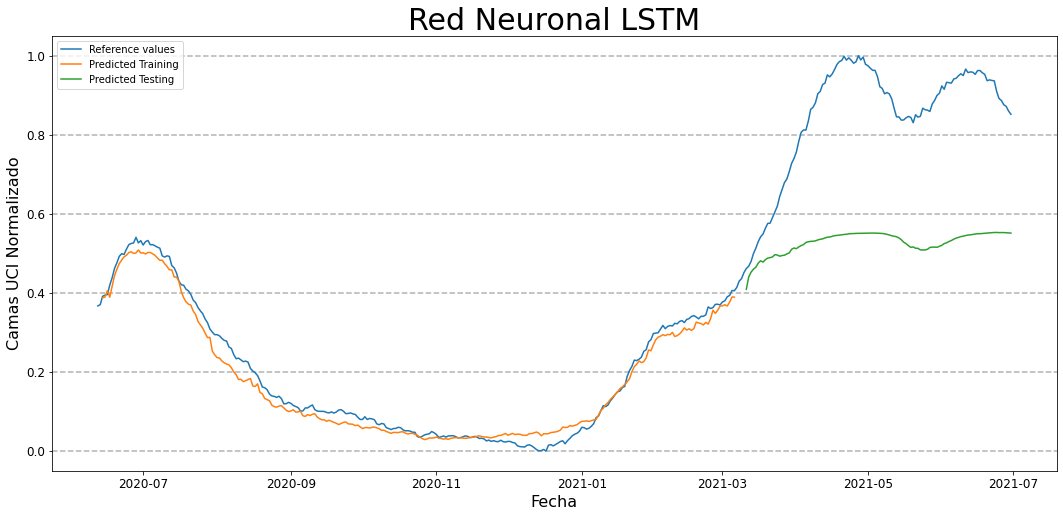

In [126]:
 fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(plotData)
#Título del gráfico
plt.title('Red Neuronal LSTM', fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Camas UCI Normalizado", fontsize=16)
ax.grid(True, 'major', 'y', ls='--', lw=1.5, c='k', alpha=.3)
ax.legend(plotData.columns,loc='upper left')
plt.show()

# Predicción camas UCI para las próximas 2 semanas
**Hasta aquí es la ultima entrega (resultados modelo) **

In [127]:
look_back = int(best_model['Lags'])
epochs=500

train_x, test_x, train_y, test_y = lags_preparation(x_train, x_test, y_train, y_test, look_back)

In [128]:
#train_x = train_x[["Camas UCI nac._t-3", "Camas UCI nac._t-2", "Camas UCI nac._t-1"]]
#test_x = test_x[["Camas UCI nac._t-3", "Camas UCI nac._t-2", "Camas UCI nac._t-1"]]

In [129]:
train_x.head()

,Camas basicas nac._t-1,Hipertensión arterial_t-1,Camas UCI ocupadas no COVID-19_t-1,Defunciones regional_t-1,Total vent._t-1,Vent. ocupados_t-1,Vent. disponibles_t-1,Promedio nacional de encierro_t-1,Primera_V_t-1,Camas UCI nac._t-1
2020-06-15,0.889785,0.000000,0.479643,0.000000,0.313036,0.378723,0.287456,0.0,0.0,0.367039
2020-06-16,0.910954,0.003514,0.414237,0.008074,0.325705,0.368085,0.301612,0.0,0.0,0.370277
2020-06-17,0.938172,0.007029,0.392435,0.008074,0.327340,0.370213,0.302792,0.0,0.0,0.391508
2020-06-18,0.952285,0.010543,0.418598,0.009931,0.375971,0.551064,0.316162,0.0,0.0,0.394386
2020-06-19,0.952957,0.014070,0.298687,0.009931,0.374745,0.521277,0.320488,0.0,0.0,0.395826


In [130]:
features = round(train_x.shape[1]/(look_back-1))

x_train_temp = custom_reshape(X=train_x.values, lags=look_back-1)
x_test_temp = custom_reshape(X=test_x.values, lags=look_back-1)

#x_train_temp = np.reshape(train_x.values, (train_x.shape[0], features, look_back-1))
#x_test_temp = np.reshape(test_x.values, (test_x.shape[0], features, look_back-1))

In [131]:
# create and fit the LSTM network
batch_size = batch
look_forward = 14
model = Sequential()
model.add(LSTM(int(best_model['Nodes layer 1']), activation=best_model['Activation Function'], batch_input_shape=(batch_size, look_back-1, features), stateful=True, return_sequences=True))
model.add(LSTM(int(best_model['Nodes layer 2']), activation=best_model['Activation Function'], batch_input_shape=(batch_size, look_back-1, features), stateful=True))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer=best_model['Optimizer Function'])

In [132]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (1, 1, 6)                 408       
_________________________________________________________________
lstm_35 (LSTM)               (1, 4)                    176       
_________________________________________________________________
dense_68 (Dense)             (1, 14)                   70        
Total params: 654
Trainable params: 654
Non-trainable params: 0
_________________________________________________________________


In [133]:
y_train_temp = train_y
y_test_temp = test_y

In [134]:
for i in range(epochs):
    model.fit(x_train_temp, y_train_temp.values, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

266/266 - 0s - loss: 0.0319
266/266 - 0s - loss: 0.0143
266/266 - 0s - loss: 0.0138
266/266 - 0s - loss: 0.0096
266/266 - 0s - loss: 0.0065
266/266 - 0s - loss: 0.0053
266/266 - 0s - loss: 0.0044
266/266 - 0s - loss: 0.0034
266/266 - 0s - loss: 0.0016
266/266 - 0s - loss: 9.3943e-04
266/266 - 0s - loss: 9.8269e-04
266/266 - 0s - loss: 0.0011
266/266 - 0s - loss: 9.8359e-04
266/266 - 0s - loss: 9.3541e-04
266/266 - 0s - loss: 9.9192e-04
266/266 - 0s - loss: 9.8328e-04
266/266 - 0s - loss: 8.5613e-04
266/266 - 0s - loss: 0.0010
266/266 - 0s - loss: 0.0013
266/266 - 0s - loss: 8.7507e-04
266/266 - 0s - loss: 7.9675e-04
266/266 - 0s - loss: 7.2514e-04
266/266 - 0s - loss: 6.9865e-04
266/266 - 0s - loss: 5.9514e-04
266/266 - 0s - loss: 5.7643e-04
266/266 - 0s - loss: 8.5988e-04
266/266 - 0s - loss: 8.8930e-04
266/266 - 0s - loss: 8.0712e-04
266/266 - 0s - loss: 6.8403e-04
266/266 - 0s - loss: 6.4395e-04
266/266 - 0s - loss: 6.5337e-04
266/266 - 0s - loss: 4.8059e-04
266/266 - 0s - loss: 4.1

266/266 - 0s - loss: 1.2110e-04
266/266 - 0s - loss: 1.0524e-04
266/266 - 0s - loss: 9.0721e-05
266/266 - 0s - loss: 7.9064e-05
266/266 - 0s - loss: 7.0510e-05
266/266 - 0s - loss: 6.3542e-05
266/266 - 0s - loss: 6.0945e-05
266/266 - 0s - loss: 9.0787e-05
266/266 - 0s - loss: 2.4485e-04
266/266 - 0s - loss: 4.7913e-04
266/266 - 0s - loss: 5.3597e-04
266/266 - 0s - loss: 3.4798e-04
266/266 - 0s - loss: 2.1272e-04
266/266 - 0s - loss: 1.2701e-04
266/266 - 0s - loss: 9.0002e-05
266/266 - 0s - loss: 9.1477e-05
266/266 - 0s - loss: 1.4267e-04
266/266 - 0s - loss: 2.1315e-04
266/266 - 0s - loss: 1.4081e-04
266/266 - 0s - loss: 1.1448e-04
266/266 - 0s - loss: 1.0367e-04
266/266 - 0s - loss: 9.7649e-05
266/266 - 0s - loss: 9.6439e-05
266/266 - 0s - loss: 9.6955e-05
266/266 - 0s - loss: 9.7086e-05
266/266 - 0s - loss: 9.8089e-05
266/266 - 0s - loss: 1.0131e-04
266/266 - 0s - loss: 1.0756e-04
266/266 - 0s - loss: 1.2161e-04
266/266 - 0s - loss: 1.7314e-04
266/266 - 0s - loss: 3.0919e-04
266/266 

In [135]:
# make predictions
trainPredict = model.predict(x_train_temp, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(x_test_temp, batch_size=batch_size)
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict)
#y_train = scaler.inverse_transform([y_train])
#testPredict = scaler.inverse_transform(testPredict)
#y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(y_train_temp.values[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(y_test_temp.values[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.41 RMSE


In [136]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (1, 1, 6)                 408       
_________________________________________________________________
lstm_35 (LSTM)               (1, 4)                    176       
_________________________________________________________________
dense_68 (Dense)             (1, 14)                   70        
Total params: 654
Trainable params: 654
Non-trainable params: 0
_________________________________________________________________


In [137]:
#trainPredict_temp = trainPredict
#testPredict_temp = testPredict

In [138]:
trainPredict = trainPredict[:,0]

In [139]:
testPredict.shape

(112, 14)

In [140]:
#today = testPredict.shape[0]
testPredictActual = testPredict[:,0]
testPredictFuture = testPredict[-1,0:]


In [141]:
testPredictFuture.shape

(14,)

In [142]:
from datetime import datetime

Y = X[[y_lab]]
last_date = data.index[-1]
predicted_dates = pd.date_range(start = last_date, periods = 14).to_pydatetime().tolist()
Y = Y.reindex(Y.index.union(predicted_dates))
#new_len = len(trainPredict) + len(predicted_dates)

In [143]:
# Create datasets for plotting
base = np.empty_like(Y)
base[:] = np.nan

In [144]:
# Create reference data
referencePlot = deepcopy(base[:])
referencePlot[:len(X),:] = X[[y_lab]]
referencePlot = pd.DataFrame(referencePlot, columns=['Reference values'], index=Y.index)

In [145]:
# Create train predict data
trainPredictPlot = deepcopy(base[:])
trainPredictPlot[look_back:len(trainPredict)+look_back,0] = trainPredict[:]
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Predicted Training'], index=Y.index)

In [146]:
# Create test predict data
testPredictPlot = deepcopy(base[:])
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(base)-len(testPredictFuture),0] = testPredictActual[:]
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Predicted Testing'], index=Y.index)

In [147]:
# Create predicted data
predictedFuturePlot = deepcopy(base[:])
predictedFuturePlot[len(base)-len(testPredictFuture):,0] = testPredictFuture[:]
predictedFuturePlot = pd.DataFrame(predictedFuturePlot, columns=['Predicted Future'],index=Y.index)

In [148]:
plotData = pd.merge(referencePlot, trainPredictPlot, how='outer', left_index=True, right_index=True)
plotData = pd.merge(plotData, testPredictPlot, how='outer', left_index=True, right_index=True)
plotData = pd.merge(plotData, predictedFuturePlot, how='outer', left_index=True, right_index=True)

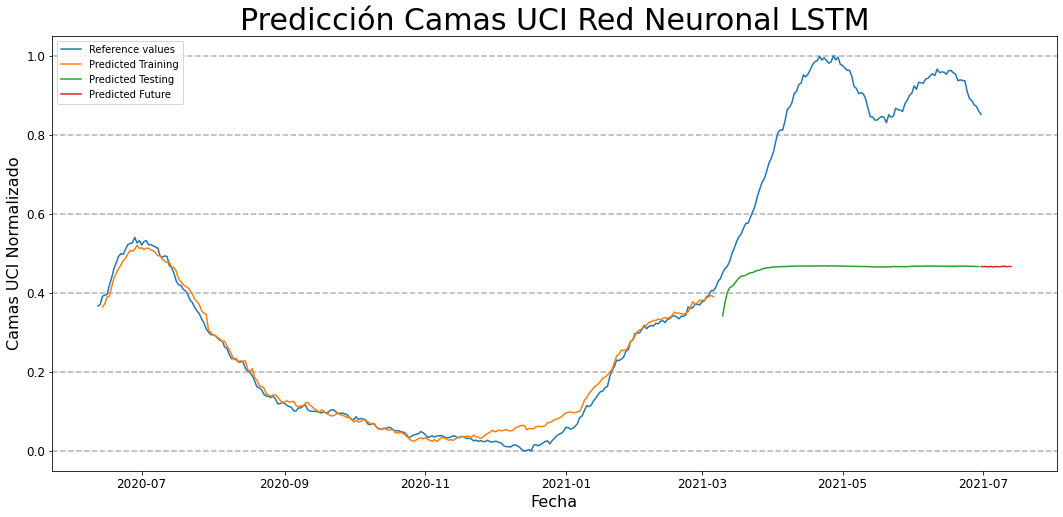

In [149]:
 fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.plot(plotData)
#Título del gráfico
plt.title('Predicción Camas UCI Red Neuronal LSTM', fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Camas UCI Normalizado", fontsize=16)
ax.grid(True, 'major', 'y', ls='--', lw=1.5, c='k', alpha=.3)
ax.legend(plotData.columns,loc='upper left')
plt.show()